In [1]:
import pandas as pd
import numpy as np
from ete3 import Tree
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import seaborn as sns
import matplotlib.pyplot as plt
import os

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
do_weighted = False

relevant_features = ["partner.diversity", # shanon diversity
                     "d", # speciality index d',
                     "normalised.degree",
                     "weighted.betweenness", # centrality,
                     "weighted.closeness",
                     "hubbiness_score"]  # generality
relevant_features += [f"standardized_{f}" for f in relevant_features]

allmb_tree_path = "../../../data/trees/ALLMB.tre"
networks_dir = "../../../data/networks/all/"
species_features_paths = {"binary": "../../../data/features/plant/binary/features_with_classification.csv",
                          "binarized_weighted": "../../../data/features/plant/binarized_weighted/features_with_classification.csv",
                          "weighted": "../../../data/features/plant/weighted/features_with_classification.csv"}

classification_path = "../../../data/ploidy_classification/plant_classification.csv"
ploidb_path = "../../../data/ploidy_classification/ploidb_by_genus_without_missing.csv"

taxonomic_data_path = "../../../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
networks_metadata_path = "../../../data/networks/all/networks_metadata.csv"
ccdb_path = "/groups/itay_mayrose/halabikeren/PloiDB/ccdb_all_data_171122.csv"
species_mating_system_data_path = "../../../data/metadata/species_level/mating_system_grossenbacher_2017.xlsx"
species_metadata_path_1 = "../../../data/metadata/species_level/plants_metadata_rice_2019.xlsx"
species_metadata_path_2 = "../../../data/metadata/species_level/LifeForm_Database.xlsx"
# species_metadata_path_3 = "../../../data/metadata/species_level/PPN_spp-floral-traits_merged.xlsx"
species_metadata_path_3 = "../../../data/metadata/species_level/PPN_spp-floral-traits_merged_CLEAN_07-06-2023.xlsx"


processed_data_path = f"../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"

pre_processed_tree_path = f"../../../data/statistical_analysis/species_level/unique_species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
processed_tree_path = f"../../../data/statistical_analysis/species_level/species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"

species_list_path = f"../../../data/statistical_analysis/species_level/species_list_{'un' if not do_weighted else ''}weighted_analysis.csv"

# process data

In [36]:
allmb_tree = Tree(allmb_tree_path, format=1)
for leaf in allmb_tree.get_leaves():
    leaf.name = leaf.name.lower().replace("_", " ")

In [37]:
relevant_columns = ["Plant", "network_id"] + relevant_features
weighted_data = pd.read_csv(species_features_paths["weighted"])
weighted_data = weighted_data.rename(columns={c: c.replace("_y","") for c in weighted_data.columns if c.endswith("_y")})
weighted_data = weighted_data[relevant_columns]
weighted_data["network_type"] = "weighted"

binarized_weighted_data = pd.read_csv(species_features_paths["binarized_weighted"])
binarized_weighted_data = binarized_weighted_data.rename(columns={c: c.replace("_y","") for c in binarized_weighted_data.columns if c.endswith("_y")})
binarized_weighted_data = binarized_weighted_data[relevant_columns]
binarized_weighted_data["network_type"] = "binarized_weighted"

binary_data = pd.read_csv(species_features_paths["binary"])
binary_data = binary_data.rename(columns={c: c.replace("_y","") for c in binary_data.columns if c.endswith("_y")})
binary_data = binary_data[relevant_columns]
binary_data["network_type"] = "binary"  

features = pd.concat([weighted_data,binarized_weighted_data,binary_data])
features["original_name"] = features.Plant.str.lower()

In [38]:
classification = pd.read_csv(classification_path).rename(columns={"polyploid_age": "ploidy_age"})

In [39]:
features_with_classification = features.merge(classification[["original_name", "resolved_name", "is_polyploid", "ploidy_age"]], on="original_name", how="left")
features_with_classification.set_index("original_name", inplace=True)
features_with_classification["is_polyploid"].fillna(classification.set_index("original_name")["is_polyploid_by_original"].to_dict(), inplace=True)
features_with_classification["ploidy_age"].fillna(classification.set_index("original_name")["polyploid_age_by_original"].to_dict(), inplace=True)
features_with_classification.reset_index(inplace=True)

In [40]:
features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / features_with_classification.shape[0]*100

is_polyploid
0.0    25.983583
1.0    21.729813
NaN    52.286604
Name: original_name, dtype: float64

In [41]:
clean_features_with_classification = features_with_classification.dropna(subset=relevant_features+["is_polyploid"], how="any", axis=0)

In [42]:
clean_features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / clean_features_with_classification.shape[0]*100

is_polyploid
0.0    54.43919
1.0    45.56081
Name: original_name, dtype: float64

In [43]:
print(f"# species from networks = {len(clean_features_with_classification.original_name.unique()):,}")
print(f"# species in tree = {len(allmb_tree.get_leaf_names()):,}")

# species from networks = 1,744
# species in tree = 356,305


## add network size data

In [44]:
if do_weighted:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type == "weighted"]
else:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type != "weighted"]

In [45]:
def get_network_size(net_path):
    try:
        net = pd.read_csv(net_path).set_index("Plant")
        num_plants = net.shape[0]
        num_pollinators = net.shape[1]
        return num_plants, num_pollinators
    except:
        return np.nan, np.nan

network_to_size = clean_features_with_classification[["network_type", "network_id"]].drop_duplicates()
network_to_size[["num_network_plants", "num_network_pollinators"]] = network_to_size.parallel_apply(lambda record: get_network_size(f"{networks_dir}{record.network_type}/{record.network_id}.csv"), axis=1, result_type="expand") 
    
clean_features_with_classification = clean_features_with_classification.merge(network_to_size, on=["network_type", "network_id"], how="left")

In [46]:
tree_names = set(allmb_tree.get_leaf_names())
final_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.original_name.isin(tree_names) |
                                                                            clean_features_with_classification.resolved_name.isin(tree_names)]
final_features_with_classification["mapped_name"] = final_features_with_classification.apply(lambda record: record.original_name if record.original_name in tree_names else record.resolved_name, axis=1)
print(f"# species from networks for analysis = {len(final_features_with_classification.mapped_name.unique()):}")

# species from networks for analysis = 1479


/tmp/ipykernel_11343/4156360445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["mapped_name"] = final_features_with_classification.apply(lambda record: record.original_name if record.original_name in tree_names else record.resolved_name, axis=1)


In [47]:
pruned_allmb_tree = allmb_tree.copy()
pruned_allmb_tree.prune(final_features_with_classification.mapped_name.unique().tolist(), preserve_branch_length=True)
print(f"# species in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# species in tree = 1,479


In [48]:
final_features_with_classification["mapped_name"] = final_features_with_classification["mapped_name"].str.replace(" ", "_")
final_features_with_classification["sample_id"] = final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network_id"].astype("str")

/tmp/ipykernel_11343/260005063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["mapped_name"] = final_features_with_classification["mapped_name"].str.replace(" ", "_")
/tmp/ipykernel_11343/260005063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["sample_id"] = final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network_id"].astype

In [49]:
final_features_with_classification.sample_id = final_features_with_classification.sample_id.str.replace(" ", "_")
for l in pruned_allmb_tree.get_leaves():
    l.name = l.name.replace(" ", "_")

/tmp/ipykernel_11343/1547168379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification.sample_id = final_features_with_classification.sample_id.str.replace(" ", "_")


In [50]:
pruned_allmb_tree.write(outfile=pre_processed_tree_path, format=5)

In [51]:
final_features_with_classification = final_features_with_classification.drop_duplicates("sample_id")

In [52]:
assert(len(final_features_with_classification.sample_id.unique().tolist()) == final_features_with_classification.shape[0])

In [53]:
# add bushes under each leaf
num_added_nodes =0
tree_leaves = pruned_allmb_tree.get_leaves()
for leaf in tree_leaves:
    children_names = final_features_with_classification.query(f"mapped_name == '{leaf.name}'").sample_id.tolist()
    if len(children_names) > 0:
        for child_name in children_names:
            leaf.add_child(name=child_name, dist=0.00001)
        num_added_nodes += len(children_names)
    else:
        print(f"no child for leaf {leaf.name}")
        leaf.dist = leaf.dist + 0
    
print(f"# added nodes = {num_added_nodes:,}")

# added nodes = 5,196


In [54]:
pruned_allmb_tree.prune(final_features_with_classification.sample_id.dropna().unique().tolist(), preserve_branch_length=True)
final_features_with_classification = final_features_with_classification.loc[final_features_with_classification.sample_id.isin(pruned_allmb_tree.get_leaf_names())]

In [55]:
print(f"# samples in data = {final_features_with_classification.shape[0]:,}")
print(f"# leaves in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# samples in data = 5,196
# leaves in tree = 5,196


In [56]:
final_features_with_classification["network_id"] = final_features_with_classification.network_type.astype(str) + "_" + final_features_with_classification.network_id.astype(str)

In [57]:
print(f"# networks = {len(final_features_with_classification.network_id.unique()):,}")

# networks = 673


In [58]:
print(f"%non-missing data: ")
final_features_with_classification.notna().sum() / final_features_with_classification.shape[0] * 100

%non-missing data: 


original_name                        100.000000
Plant                                100.000000
network_id                           100.000000
partner.diversity                    100.000000
d                                    100.000000
normalised.degree                    100.000000
weighted.betweenness                 100.000000
weighted.closeness                   100.000000
hubbiness_score                      100.000000
standardized_partner.diversity       100.000000
standardized_d                       100.000000
standardized_normalised.degree       100.000000
standardized_weighted.betweenness    100.000000
standardized_weighted.closeness      100.000000
standardized_hubbiness_score         100.000000
network_type                         100.000000
resolved_name                         98.575828
is_polyploid                         100.000000
ploidy_age                            99.980754
num_network_plants                   100.000000
num_network_pollinators              100

In [59]:
final_features_with_classification["network_size"] = final_features_with_classification.num_network_plants + final_features_with_classification.num_network_pollinators

In [60]:
final_features_with_classification.to_csv(processed_data_path)
pruned_allmb_tree.write(outfile=processed_tree_path)

In [61]:
species = final_features_with_classification.mapped_name.str.replace("_"," ").unique()
pd.Series(species).to_csv(species_list_path)

# plot features distributions

In [62]:
final_features_with_classification = pd.read_csv(processed_data_path)

In [63]:
final_features_with_classification.is_polyploid = final_features_with_classification.is_polyploid.replace({1.0: "Polyploids", 0.0: "Diploids"})
features_by_ploidy = final_features_with_classification.groupby("is_polyploid")

/tmp/ipykernel_11343/1878803736.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)


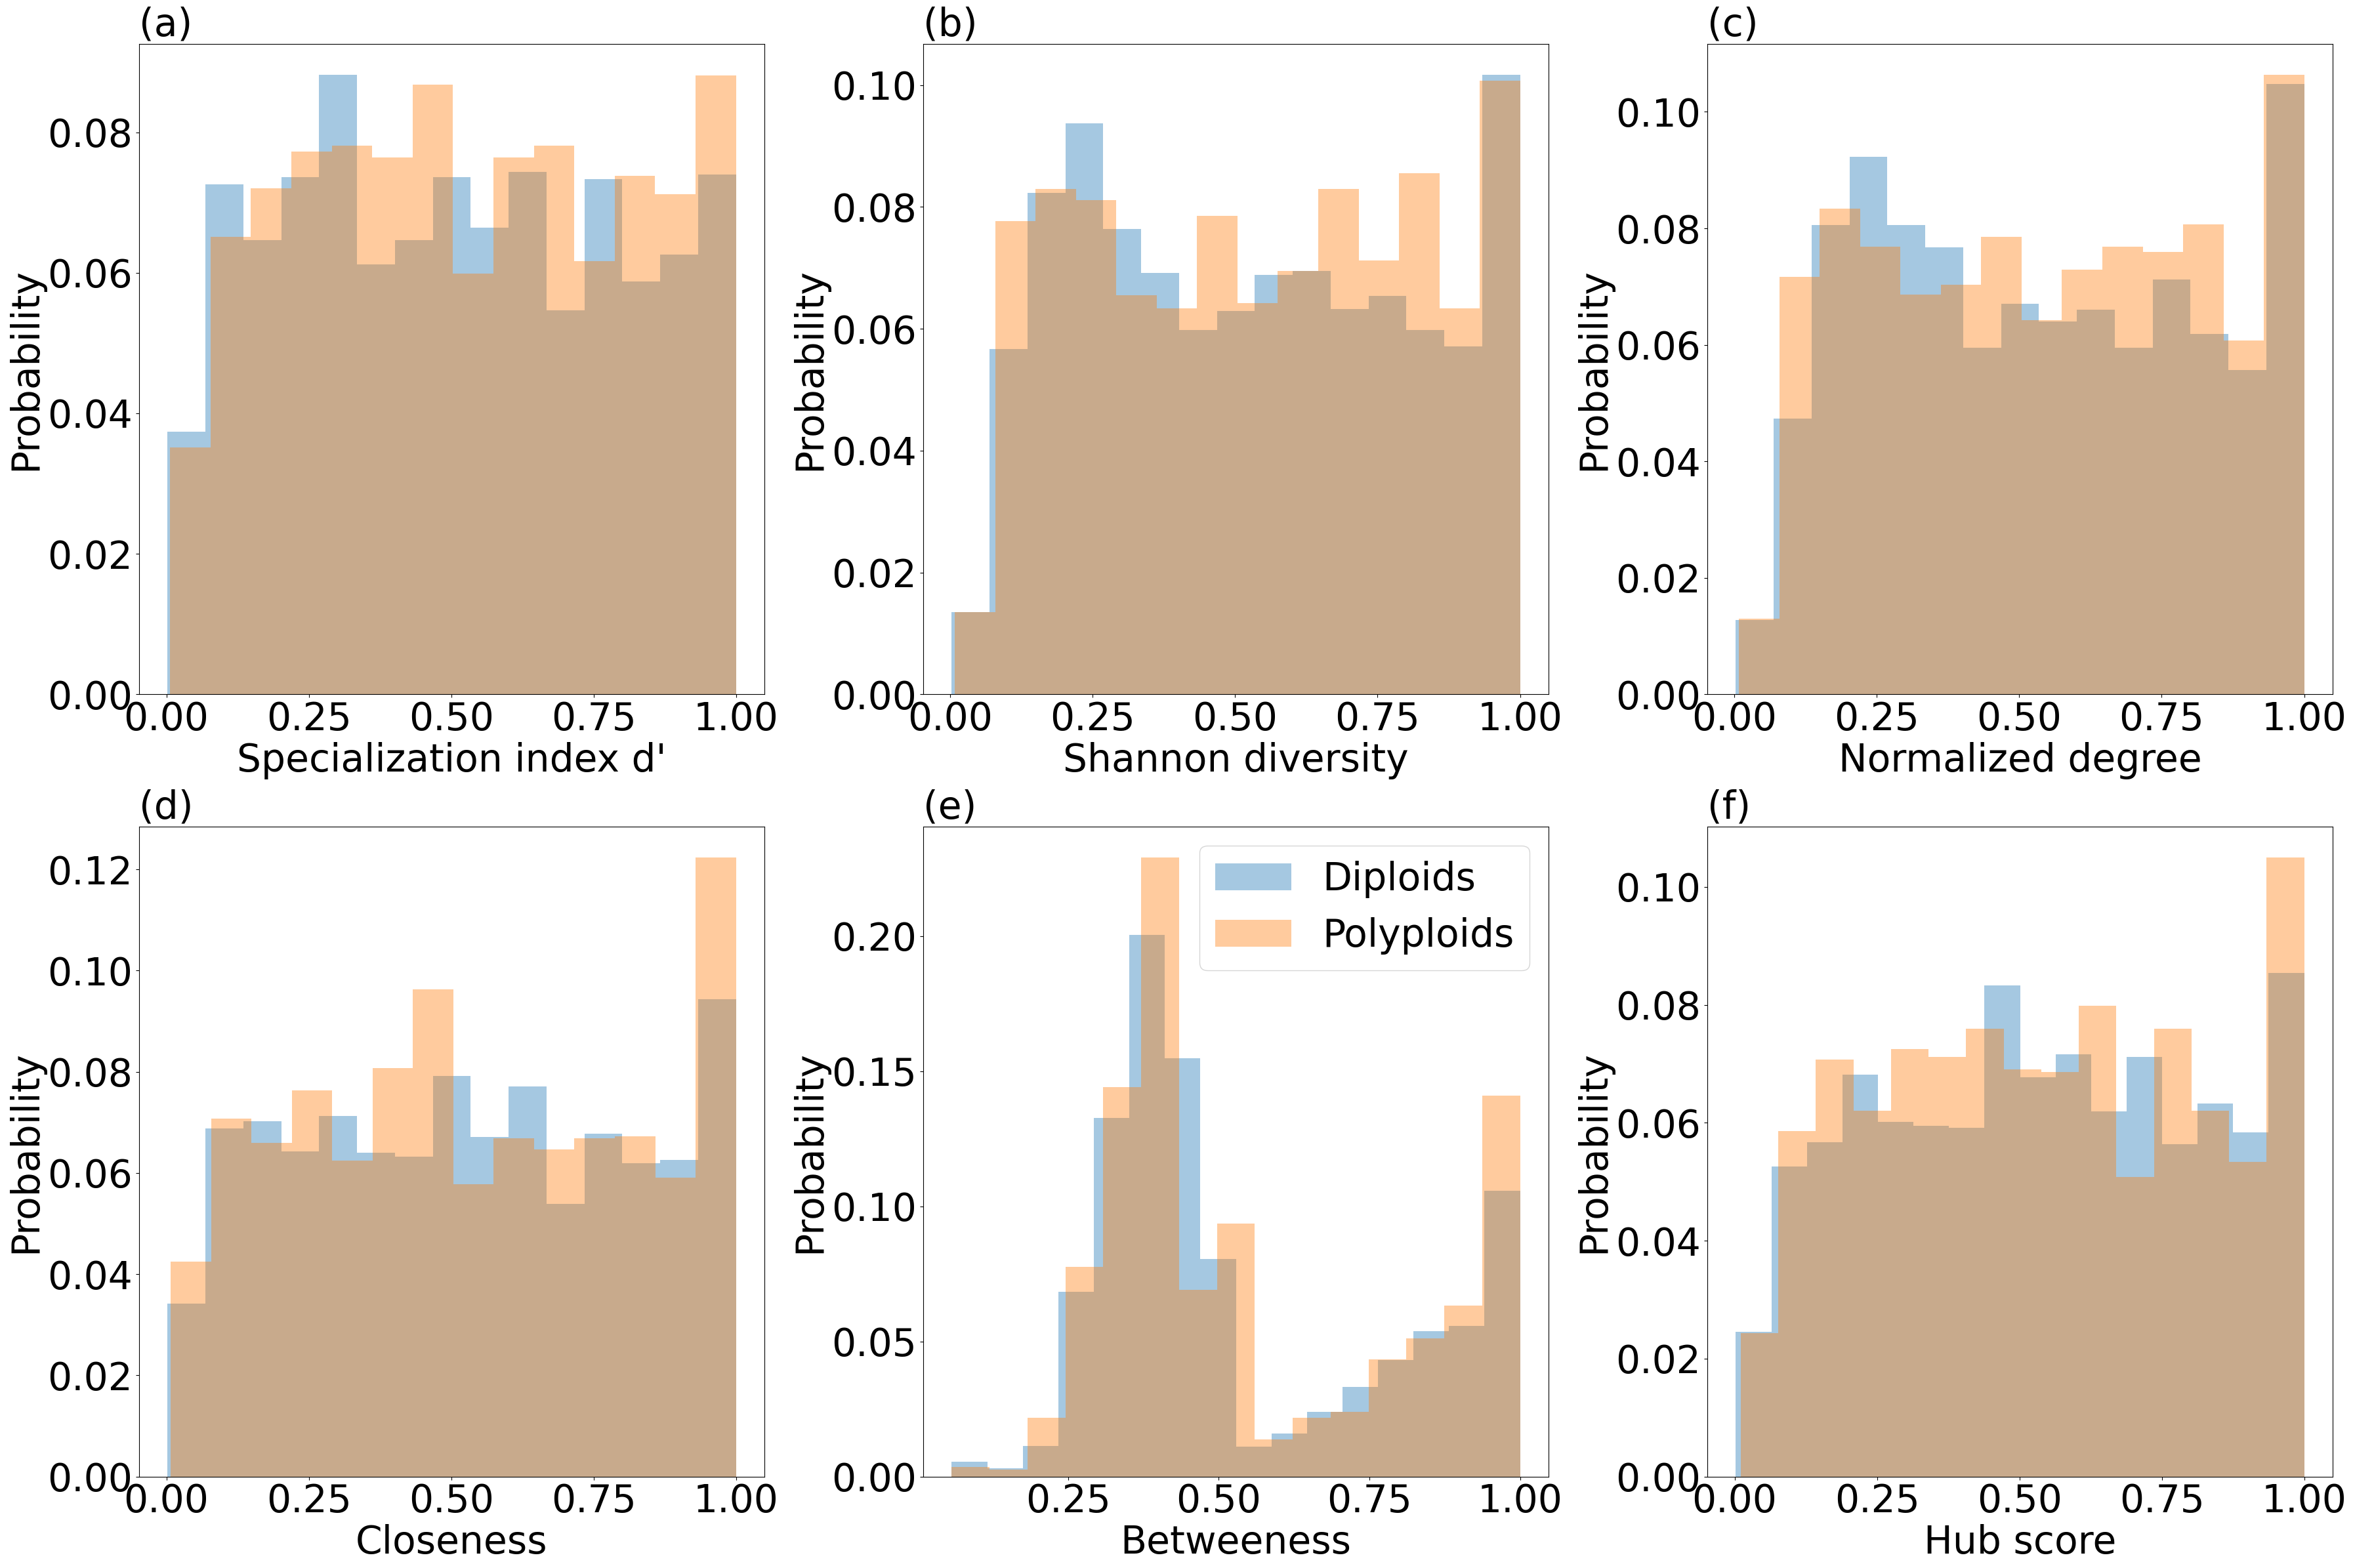

In [64]:
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, ax = plt.subplots(figsize=(3*12, 2*12))
# fig.suptitle(f"Indices distribution across {features_by_ploidy.get_group('Polyploids').shape[0]:,} polyploids and {features_by_ploidy.get_group('Diploids').shape[0]:,} diploids", fontsize=fontsize)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2, fig=fig)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2, fig=fig)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_d"], label="Diploids", color=di_color, ax=ax1, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_d"], label="Polyploids", ax=ax1, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax1.set_xlabel("Specialization index d'", fontsize=fontsize)
ax1.set_ylabel("Probability", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize)
ax1.set_title("(a)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_partner.diversity"], label="Diploids", color=di_color, ax=ax2, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_partner.diversity"], label="Polyploids", ax=ax2, color=poly_color, stat="probability",alpha=alpha, linewidth=0)
ax2.set_xlabel("Shannon diversity", fontsize=fontsize)
ax2.set_ylabel("Probability", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize)
ax2.set_title("(b)", loc="left", fontsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_normalised.degree"], label="Diploids", color=di_color, ax=ax3, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_normalised.degree"], label="Polyploids", ax=ax3, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax3.set_xlabel("Normalized degree", fontsize=fontsize)
ax3.set_ylabel("Probability", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize)
ax3.set_title("(c)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.closeness"], label="Diploids", color=di_color, ax=ax4, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.closeness"], label="Polyploids", ax=ax4, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax4.set_xlabel("Closeness", fontsize=fontsize)
ax4.set_ylabel("Probability", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.tick_params(axis='both', which='minor', labelsize=fontsize)
ax4.set_title("(d)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.betweenness"], label="Diploids", color=di_color, ax=ax5, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.betweenness"], label="Polyploids", ax=ax5, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax5.set_xlabel("Betweeness", fontsize=fontsize)
ax5.legend(prop={'size': fontsize})
ax5.set_ylabel("Probability", fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.tick_params(axis='both', which='minor', labelsize=fontsize)
ax5.set_title("(e)", loc="left", fontsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_hubbiness_score"], label="Diploids", color=di_color, ax=ax6, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_hubbiness_score"], label="Polyploids", ax=ax6, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax6.set_xlabel("Hub score", fontsize=fontsize)
ax6.set_ylabel("Probability", fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.tick_params(axis='both', which='minor', labelsize=fontsize)
ax6.set_title("(f)", loc="left", fontsize=fontsize)

fig.tight_layout()
fig.savefig(f"../../../data/figures/fig1_{'weighted' if do_weighted else 'binary'}.jpeg")

/tmp/ipykernel_11343/1359977466.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


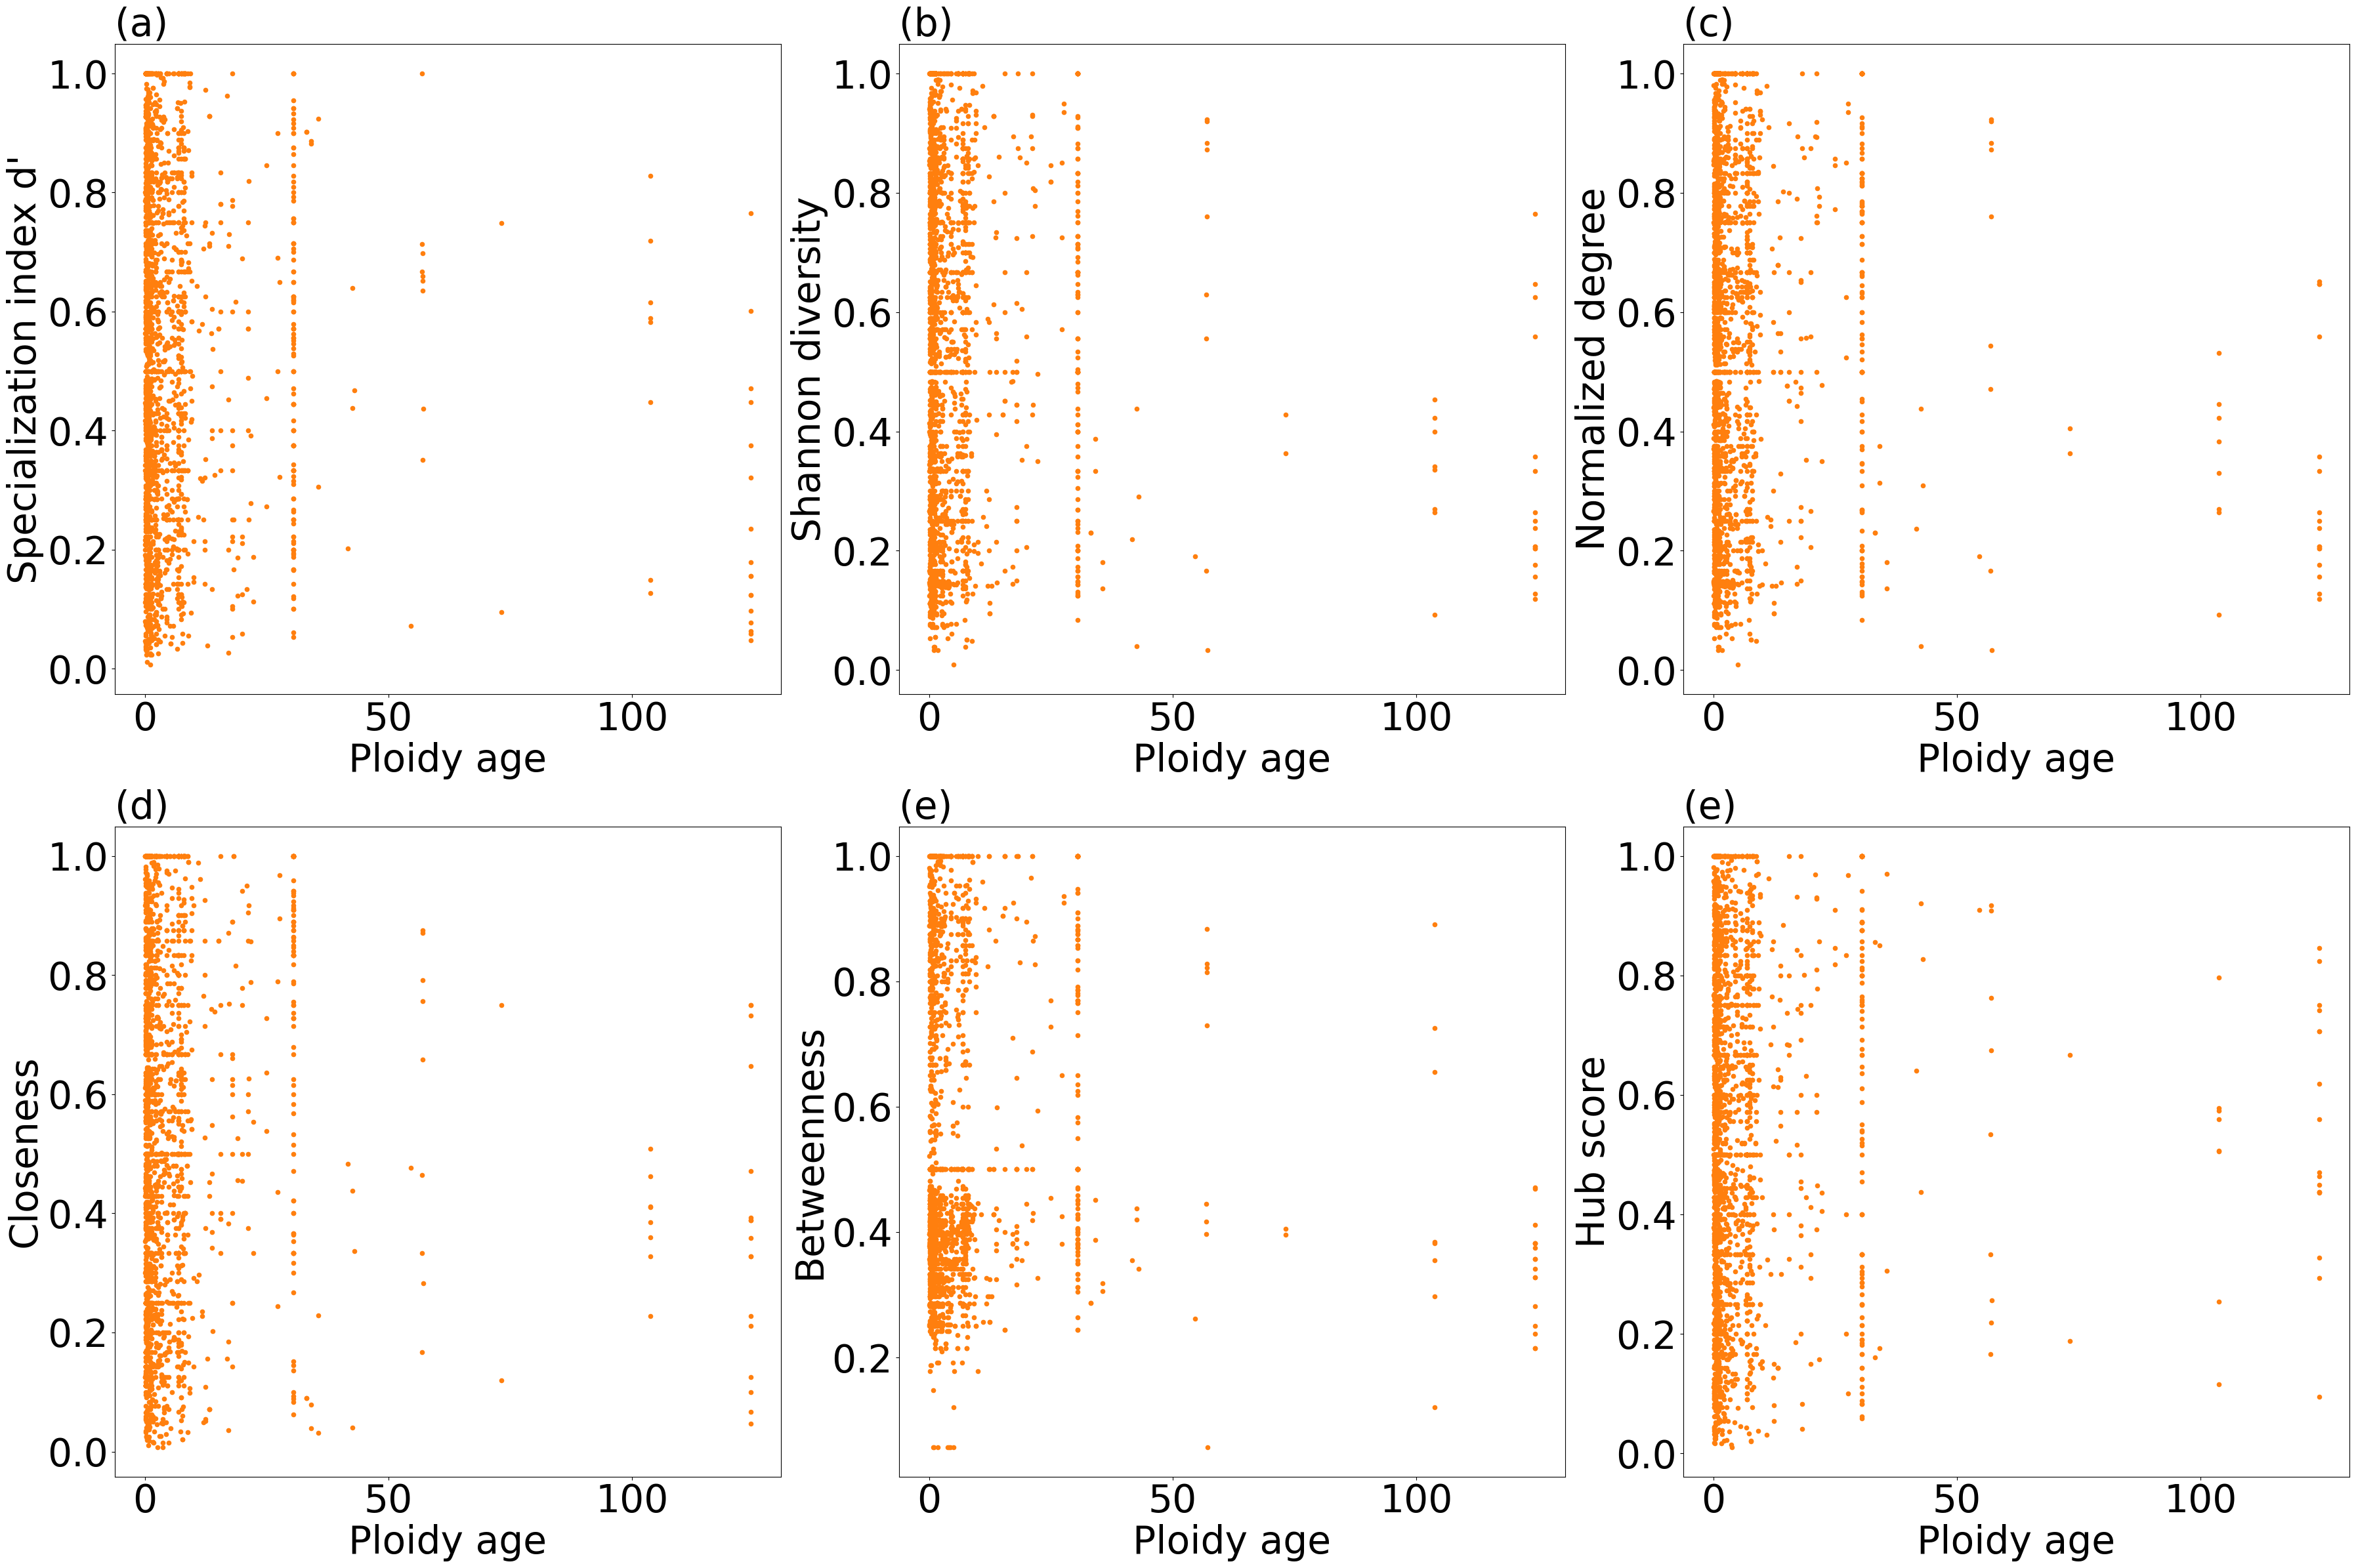

In [65]:
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, ax = plt.subplots(figsize=(3*12, 2*12))
polyploids = features_by_ploidy.get_group("Polyploids")

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2, fig=fig)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2, fig=fig)


polyploids.plot.scatter(x="ploidy_age", y="standardized_d", color=poly_color, ax=ax1)
ax1.set_ylabel("Specialization index d'", fontsize=fontsize)
ax1.set_xlabel("Ploidy age", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.set_title("(a)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_partner.diversity", color=poly_color, ax=ax2)
ax2.set_ylabel("Shannon diversity", fontsize=fontsize)
ax2.set_xlabel("Ploidy age", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_title("(b)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_normalised.degree", color=poly_color, ax=ax3)
ax3.set_ylabel("Normalized degree", fontsize=fontsize)
ax3.set_xlabel("Ploidy age", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.set_title("(c)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_weighted.closeness", color=poly_color, ax=ax4)
ax4.set_ylabel("Closeness", fontsize=fontsize)
ax4.set_xlabel("Ploidy age", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.set_title("(d)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_weighted.betweenness", color=poly_color, ax=ax5)
ax5.set_ylabel("Betweenness", fontsize=fontsize)
ax5.set_xlabel("Ploidy age", fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.set_title("(e)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_hubbiness_score", color=poly_color, ax=ax6)
ax6.set_ylabel("Hub score", fontsize=fontsize)
ax6.set_xlabel("Ploidy age", fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.set_title("(e)", loc="left", fontsize=fontsize)


fig.tight_layout()
fig.savefig(f"../../../data/figures/fig_pl_age_{'weighted' if do_weighted else 'binary'}.jpeg")

In [66]:
from scipy.stats import ks_2samp

for feature in relevant_features:
    if not "standardized" in feature:
        continue
    dres = ks_2samp(features_by_ploidy.get_group("Diploids")[feature], features_by_ploidy.get_group("Polyploids")[feature])
    if dres.pvalue <= 0.05:
        print(f"# KS test for comparison of {feature} distribution across diploids and polyploids = {dres}")

# KS test for comparison of standardized_partner.diversity distribution across diploids and polyploids = KstestResult(statistic=0.04674713289534348, pvalue=0.007061531115152386)
# KS test for comparison of standardized_d distribution across diploids and polyploids = KstestResult(statistic=0.04504163785154449, pvalue=0.01056813403445173)
# KS test for comparison of standardized_normalised.degree distribution across diploids and polyploids = KstestResult(statistic=0.04603215767634855, pvalue=0.008377109141624938)
# KS test for comparison of standardized_weighted.betweenness distribution across diploids and polyploids = KstestResult(statistic=0.04399889061779622, pvalue=0.013423225254238036)


# add network-level metadata when available

In [67]:
final_features_with_classification = pd.read_csv(processed_data_path)
networks_metadata = pd.read_csv(networks_metadata_path)

In [68]:
networks_metadata_rel_cols = ['Annual Mean Temperature',
 'Mean Diurnal Range (Mean of monthly (max temp - min temp))',
 'Isothermality (BioClim_2/BioClim_7) (×100)',
 'Temperature Seasonality (standard deviation ×100)',
 'Max Temperature of Warmest Month',
 'Min Temperature of Coldest Month',
 'Temperature Annual Range (BioClim_5-BioClim_6)',
 'Mean Temperature of Wettest Quarter',
 'Mean Temperature of Driest Quarter',
 'Mean Temperature of Warmest Quarter',
 'Mean Temperature of Coldest Quarter',
 'Annual Precipitation',
 'Precipitation of Wettest Month',
 'Precipitation of Driest Month',
 'Precipitation Seasonality (Coefficient of Variation)',
 'Precipitation of Wettest Quarter',
 'Precipitation of Driest Quarter',
 'Precipitation of Warmest Quarter',
 'Precipitation of Coldest Quarter',
 'species_richness',
 'EcoRegion',
 'EcoRegion_name',
 'highest_pollinator_rank_index',
 'highest_pollinator_rank_name',
 'Paleo2',
 'Paleo4',
 'Difference in glaciers',
 'Woody %',
 'Annual %',
 'Basal angiosperm %',
 'Diploids',
 'Paleo12',
 'Taxonomy_PC1',
 'Paleo14',
 'Taxonomy_PC3',
 'ChangeInClimate_PC3',
 'Polyploids',
 'Paleo19',
 'Paleo16',
 'Asterids %',
 'Lifeform_PC3',
 'ChangeInClimate_PC2',
 'Paleo8',
 'Current glaciers',
 'Paleo6',
 'Species richness',
 'Basal dicots %',
 'Climate_PC3',
 'Paleo10',
 'Altitude',
 'Paleo9',
 'Paleo7',
 'Polyploid percent',
 'Biome frequency',
 'Human footprint',
 'Elevation amplitude',
 'Binomial PV',
 'Paleo3',
 'Taxonomy_PC2',
 'Climate_PC1',
 'Paleo15',
 'Species',
 'Lifeform_PC2',
 'NPP',
 'Commelinids %',
 'Lifeform_PC1',
 'Basal monocots %',
 'Rosids %',
 'Paleo13',
 'Paleo18',
 'Occurrences',
 'Paleo1',
 'Paleo17',
 'Paleo5',
 'Paleo11',
 'Climate_PC2',
 'Phosphorus retention',
 'ChangeInClimate_PC1',
 'LGM glaciers',
 'Perennial herb %']

In [69]:
final_features_with_classification["network_index"] = final_features_with_classification.network_id.apply(lambda x: int(x.split("_")[-1]))

In [70]:
final_features_with_classification = final_features_with_classification.merge(networks_metadata[["network_type", "network_index"] + networks_metadata_rel_cols], on=["network_type", "network_index"], how="left")
final_features_with_classification = final_features_with_classification[[c for c in final_features_with_classification.columns if "Unnamed" not in c]]
final_features_with_classification = final_features_with_classification.drop_duplicates(subset=["original_name", "network_id"])
final_features_with_classification[networks_metadata_rel_cols].notna().sum() / final_features_with_classification.shape[0]

Annual Mean Temperature                                       0.456890
Mean Diurnal Range (Mean of monthly (max temp - min temp))    0.456890
Isothermality (BioClim_2/BioClim_7) (×100)                    0.456890
Temperature Seasonality (standard deviation ×100)             0.456890
Max Temperature of Warmest Month                              0.456890
                                                                ...   
Climate_PC2                                                   0.891263
Phosphorus retention                                          0.808891
ChangeInClimate_PC1                                           0.891263
LGM glaciers                                                  0.784834
Perennial herb %                                              0.891263
Length: 80, dtype: float64

In [71]:
final_features_with_classification.to_csv(processed_data_path, index=False)

# add flag to ploidy variably within species based on chromosome numbers from ccdb

In [79]:
final_features_with_classification = pd.read_csv(processed_data_path)
ccdb = pd.read_csv(ccdb_path)
ccdb.mapped_name = ccdb.mapped_name.str.replace("-", " ")

In [87]:
# TO DO: maybe set a continnuos measure that will enable a threshold based decision of inclusion / exclusion
def get_ploidy_variablity_flag(chromosome_counts: pd.Series) -> bool:
    chromosome_counts = chromosome_counts.dropna()
    min_cc = np.min(chromosome_counts)
    max_cc = np.max(chromosome_counts)
    if max_cc > int(min_cc*1.5):
        return True
    return False

name_to_ploidy_variablity_flag = ccdb.groupby("mapped_name")["parsed_n"].apply(get_ploidy_variablity_flag).reset_index().rename(columns={"parsed_n": "has_ploidy_variablity"})

In [88]:
final_features_with_classification = final_features_with_classification.merge(name_to_ploidy_variablity_flag, left_on="resolved_name", right_on="mapped_name", how="left")
d = name_to_ploidy_variablity_flag.set_index("mapped_name")["has_ploidy_variablity"].to_dict()
final_features_with_classification.loc[final_features_with_classification.has_ploidy_variablity.isna(), "has_ploidy_variablity"] = final_features_with_classification.original_name.apply(lambda n: d.get(n, np.nan))

In [90]:
print(f"# species with no ploidy level variability = {final_features_with_classification.query('has_ploidy_variablity == 0').shape[0]}")
print(f"% species with no ploidy level variability = {np.round(final_features_with_classification.query('has_ploidy_variablity == 0').shape[0]/final_features_with_classification.shape[0]*100,2)}%")

# species with no ploidy level variability = 2334
% species with no ploidy level variability = 44.92%


In [91]:
final_features_with_classification.to_csv(processed_data_path, index=False)

# add species-level metadata where available

In [16]:
final_features_with_classification = pd.read_csv(processed_data_path)

In [92]:
species_mating_system_data = pd.read_excel(species_mating_system_data_path, header=1, sheet_name="Table S3")
nr_unresolved = pd.read_csv(f"{os.path.dirname(species_mating_system_data_path)}/temp_nr_mating_system_data_path/unresolved_names.csv")
nr_resolved = pd.read_csv(f"{os.path.dirname(species_mating_system_data_path)}/temp_nr_mating_system_data_path/resolved_names.csv")
species_mating_system_data = species_mating_system_data.merge(nr_unresolved[["Name", "Id"]], left_on="OrigSpecies", right_on="Name", how="left")
species_mating_system_data = species_mating_system_data.merge(nr_resolved[["Id", "Coded Name", "Matched Name"]], on="Id", how="left").rename(columns={"Coded Name": "resolved_name",                                                                                                                                                  "Matched Name": "matched_name"})
species_mating_system_data.resolved_name = species_mating_system_data.resolved_name.str.replace("_", " ")
species_mating_system_data["species"] = species_mating_system_data.AccGenus.str.lower() + " " + species_mating_system_data.AccSpecies.str.lower()
species_mating_system_data.OrigSpecies = species_mating_system_data.OrigSpecies.str.lower()
species_mating_system_data.resolved_name = species_mating_system_data.resolved_name.str.lower()
species_mating_system_data.matched_name = species_mating_system_data.matched_name.str.lower()

sp_to_ms = species_mating_system_data.set_index('species')['bs'].to_dict()
orig_name_to_ms = species_mating_system_data.set_index('OrigSpecies')['bs'].to_dict()
resolved_name_to_ms = species_mating_system_data.dropna(subset=["resolved_name", "bs"]).set_index('resolved_name')['bs'].to_dict()

In [93]:
species_metadata_1 = pd.read_excel(species_metadata_path_1, header=1)
species_metadata_1.Species = species_metadata_1.Species.str.lower().str.replace("_"," ")

In [94]:
species_metadata_2 = pd.read_excel(species_metadata_path_2)
species_metadata_2['Accepted Name'] = species_metadata_2['Accepted Name'].str.lower().str.replace("_"," ")

In [95]:
species_metadata_3 = pd.read_excel(species_metadata_path_3, sheet_name="Data")
relevant_cols = ["scientificName", "mating_system_literature", "flw_symmetry",
                     "flw_shape", "flw_color", "flw_size_mean", "num_of_flw_infl"]
species_metadata_3.scientificName = species_metadata_3.scientificName.str.lower()
species_metadata_3.flw_size_mean = species_metadata_3.flw_size_mean.replace({"save": np.nan}).astype(float)

/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## mating system data

In [96]:
final_features_with_classification["resolved_species"] = final_features_with_classification.resolved_name.apply(lambda x: " ".join(x.split(" ")[:2]) if pd.notna(x) else x)
final_features_with_classification["mating_system"] = np.nan
final_features_with_classification.loc[final_features_with_classification.mating_system.isna(), "mating_system"] = final_features_with_classification.resolved_species.apply(lambda x: sp_to_ms.get(x, np.nan))
final_features_with_classification.loc[final_features_with_classification.mating_system.isna(), "mating_system"] = final_features_with_classification.original_name.apply(lambda x: orig_name_to_ms.get(x, np.nan))
final_features_with_classification.loc[final_features_with_classification.mating_system.isna(), "mating_system"] = final_features_with_classification.resolved_name.apply(lambda x: resolved_name_to_ms.get(x, np.nan))

In [97]:
final_features_with_classification = final_features_with_classification.merge(species_metadata_3[relevant_cols], left_on="original_name", right_on="scientificName", how="left")
final_features_with_classification = final_features_with_classification.drop(["scientificName"], axis=1)
final_features_with_classification.mating_system = final_features_with_classification[["mating_system", "mating_system_literature"]].apply(lambda rec: rec.dropna().values[0] if len(rec.dropna().values) > 0 else np.nan, axis=1)
final_features_with_classification = final_features_with_classification.drop(["mating_system_literature"], axis=1)
final_features_with_classification.mating_system = final_features_with_classification.mating_system.replace({"dioecious": "SI",
                                                                                                             "monoecious": "SC"})
print(f"# samples with mating system data = {final_features_with_classification.mating_system.notna().sum():,}")

# samples with mating system data = 2,681


In [98]:
final_features_with_classification.to_csv(processed_data_path, index=False)

## growth and life form data

In [99]:
final_features_with_classification = final_features_with_classification.merge(species_metadata_1, left_on="resolved_name", right_on="Species", how="left")

In [100]:
display(final_features_with_classification[set(species_metadata_1.columns)&set(final_features_with_classification.columns)].notna().sum())

/tmp/ipykernel_11343/2167538041.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  display(final_features_with_classification[set(species_metadata_1.columns)&set(final_features_with_classification.columns)].notna().sum())


Growth_form    4619
Life_cycle     4500
Lifeform       4694
dtype: int64

In [101]:
final_features_with_classification = final_features_with_classification.merge(species_metadata_2, left_on="resolved_name", right_on="Accepted Name", how="left")

In [102]:
final_features_with_classification["LifeCycle"] = final_features_with_classification["LifeCycle"].fillna(final_features_with_classification["Life_cycle"])
final_features_with_classification = final_features_with_classification.drop(["Life_cycle", "Accepted Name"], axis=1)

In [103]:
final_features_with_classification.Lifeform = final_features_with_classification.Lifeform.str.lower()

In [104]:
final_features_with_classification["Woodiness"] = final_features_with_classification["Woodiness"].replace({"Non-Woody": "herb", "Woody": "woody"}).fillna(final_features_with_classification["Growth_form"])
final_features_with_classification = final_features_with_classification.drop(["Growth_form"], axis=1)
final_features_with_classification = final_features_with_classification.rename(columns={"Woodiness": "Growth_form"})

In [105]:
final_features_with_classification[set(["original_name", "resolved_name"] + 
                                   [c for c in species_metadata_1.columns if c in final_features_with_classification.columns] + 
                                   [c for c in species_metadata_2.columns if c in final_features_with_classification.columns])].head()

/tmp/ipykernel_11343/1271131495.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  final_features_with_classification[set(["original_name", "resolved_name"] +


Family  LifeCycle         Genus Growth_form  \
0    Elaeocarpaceae  Perennial   Aristotelia       woody   
1  Alstroemeriaceae  Perennial  Alstroemeria        herb   
2     Berberidaceae  Perennial      Berberis       woody   
3          Fabaceae  Perennial         Vicia        herb   
4        Asteraceae  Perennial       Mutisia       woody   

                  Raunkiaer_LifeForm          resolved_name  \
0  Phanerophyte AND Nanophanerophyte  aristotelia chilensis   
1                           Geophyte     alstroemeria aurea   
2                   Nanophanerophyte      berberis darwinii   
3                    Hemicryptophyte        vicia nigricans   
4                                NaN      mutisia decurrens   

           original_name USDA_Definitions        Lifeform  
0  aristotelia chilensis            Shrub           woody  
1     alstroemeria aurea             Herb  perennial herb  
2      berberis darwinii            Shrub           woody  
3        vicia nigricans              NaN  perennial herb  
4      mutisia decurrens            Liana           woody

In [152]:
def complement_lifeform(record: pd.Series):
    gf = record.Growth_form
    lc = record.LifeCycle
    rank = record.Raunkiaer_LifeForm
    if lc == "annual":
        return "annual"
    elif gf == "woody":
        return "woody"
    elif rank == "Therophyte":
        return "annual"
    else:
        if lc == "herb" or rank in ["Chamaephyte", "Hemicryptophyte"]:
            return "perennial herb"
    if lc == "herb":
        return "unclassified herb"
    return record.Lifeform

def classify_lifeform(record:pd.Series):
    lf = record.Lifeform
    gf = record.Growth_form
    lc = record.LifeCycle
    if lf.endswith("perennial"): 
        if gf == "herb":
            return "perennial herb"
        elif gf == "mixed":
            return "perennial mixed"
    elif lf.endswith("herb"):
        if lc == "Perennial":
            return "perennial herb"
        elif lc == "mixed":
            return "mixed herb"
    return lf
    
            
final_features_with_classification.LifeCycle = final_features_with_classification.LifeCycle.str.lower()
final_features_with_classification.Growth_form = final_features_with_classification.Growth_form.str.lower()
final_features_with_classification.loc[final_features_with_classification.Lifeform.isna(), "Lifeform"] = final_features_with_classification.apply(complement_lifeform, axis=1)
final_features_with_classification.loc[final_features_with_classification.Lifeform.str.startswith("unclassified"), "Lifeform"] = final_features_with_classification.apply(classify_lifeform, axis=1)

In [47]:
final_features_with_classification.query("Lifeform.str.contains('mixed')")[["resolved_name", "Lifeform", "Growth_form", "LifeCycle", "Raunkiaer_LifeForm"]].to_csv("mixed_lifeforms_for_categorization.csv", index=False)

In [155]:
final_features_with_classification.groupby("Lifeform").Plant.count()

Lifeform
annual                     531
mixed herb                  63
perennial herb            3515
perennial mixed             60
unclassified herb           38
unclassified perennial     200
woody                      789
Name: Plant, dtype: int64

In [156]:
final_features_with_classification.query("Lifeform.str.startswith('unclass')")[["resolved_name", "Lifeform", "Growth_form",	"Raunkiaer_LifeForm", "LifeCycle"]].drop_duplicates().to_csv("sp_for_lifeform_complementing.csv", index=False)

In [157]:
final_features_with_classification.to_csv(processed_data_path, index=False)

## flower trait data

In [162]:
final_features_with_classification[list(set(final_features_with_classification.columns)&set(relevant_cols)) + ["mating_system"]].notna().sum()

flw_shape          4773
num_of_flw_infl    4773
flw_symmetry       4752
flw_size_mean      3829
flw_color          4769
mating_system      2681
dtype: int64

In [171]:
final_features_with_classification.num_of_flw_infl = final_features_with_classification.num_of_flw_infl.str.replace("sinlgle", "single")

In [173]:
for feat in list(set(final_features_with_classification.columns)&set(relevant_cols)) + ["mating_system"]:
    if len(final_features_with_classification[feat].unique()) < 10:
        if final_features_with_classification[feat].dtype == object:
            final_features_with_classification[feat] = final_features_with_classification[feat].str.replace(" ", "")
        display(final_features_with_classification.groupby(feat).Plant.count())
        print("\n\n")

flw_shape
restrictive      2060
unrestrictive    2713
Name: Plant, dtype: int64

num_of_flw_infl
multiple    4069
single       704
Name: Plant, dtype: int64

flw_symmetry
actinomorphic    3529
zygomorphic      1223
Name: Plant, dtype: int64

mating_system
SC              1089
SI              1438
partially_SC     154
Name: Plant, dtype: int64

In [174]:
final_features_with_classification.to_csv(processed_data_path, index=False)

# check for co-linearity

In [175]:
df = pd.read_csv(processed_data_path)

In [176]:
features = ["is_polyploid", "Lifeform", "flw_symmetry", "flw_shape", "flw_color", "flw_size_mean", "num_of_flw_infl", "mating_system"]
df[features].notna().sum()

is_polyploid       5196
Lifeform           5196
flw_symmetry       4752
flw_shape          4773
flw_color          4769
flw_size_mean      3829
num_of_flw_infl    4773
mating_system      2681
dtype: int64

is_polyploid
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: flw_size_mean, dtype: object

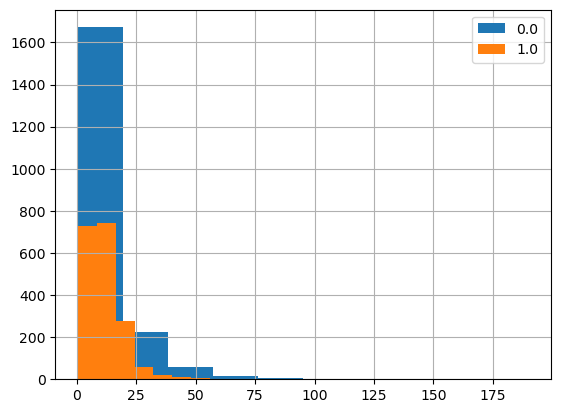

In [181]:
df.groupby("is_polyploid").flw_size_mean.hist(legend=True)

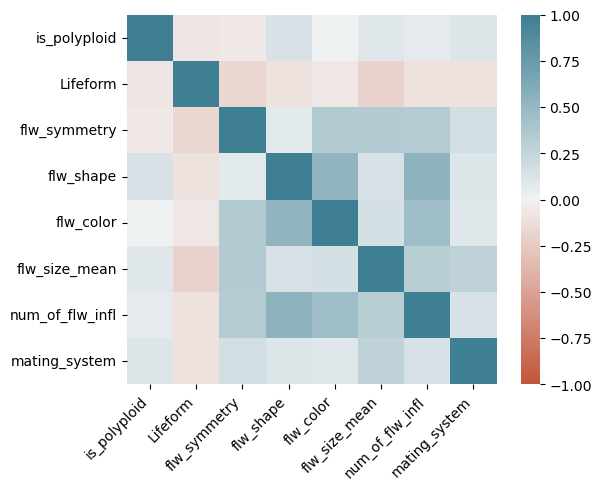

In [177]:
for f in features:
    df[f] = pd.Categorical(df[f]).codes
    
an_corr_only_rel = df[features].corr()

ax = sns.heatmap(
    an_corr_only_rel, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [131]:
subdf.to_csv(processed_data_path.replace(".csv", "_only_prevalent.csv"), index=False)

In [183]:
features = ["is_polyploid", "network_index", "network_size", "Lifeform", "flw_symmetry", "flw_shape", "flw_color", "num_of_flw_infl", "mating_system"]
df = pd.read_csv(processed_data_path)
for f in features:
    df[f] = df[f].apply(lambda n: n.lower().replace(" ","") if type(n) == str else n)
    if f not in ["network_index", "network_size"]:
        print(f)
        print(df[f].dropna().unique().tolist())

is_polyploid
[0.0, 1.0]
Lifeform
['woody', 'perennialherb', 'unclassifiedperennial', 'annual', 'mixedherb', 'unclassifiedherb', 'perennialmixed']
flw_symmetry
['actinomorphic', 'zygomorphic']
flw_shape
['restrictive', 'unrestrictive']
flw_color
['yellow', 'red', 'multiple', 'orange', 'green', 'purple', 'white_cream', 'pink', 'blue', 'brown']
num_of_flw_infl
['multiple', 'single']
mating_system
['sc', 'si', 'partially_sc']


In [184]:
df.to_csv(processed_data_path, index=False)

/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='standardized_normalised.degree', ylabel='standardized_partner.diversity'>

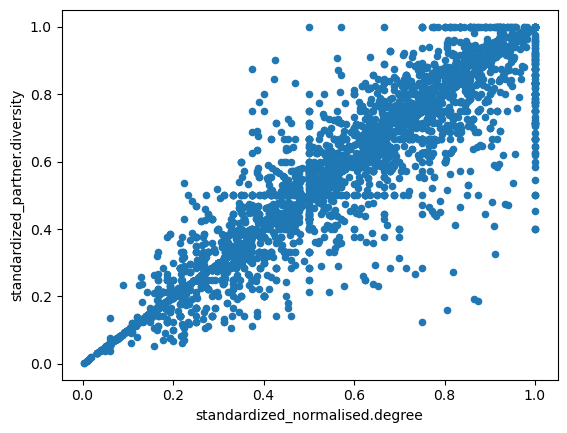

In [185]:
df.plot.scatter(x="standardized_normalised.degree", y="standardized_partner.diversity")

<AxesSubplot: xlabel='d', ylabel='standardized_partner.diversity'>

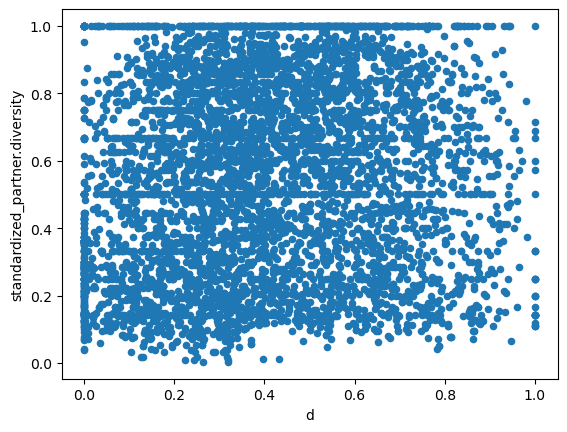

In [186]:
df.plot.scatter(x="d", y="standardized_partner.diversity")

<AxesSubplot: xlabel='d', ylabel='standardized_normalised.degree'>

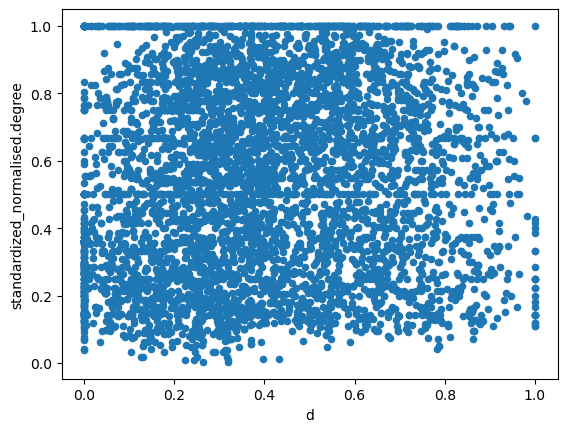

In [187]:
df.plot.scatter(x="d", y="standardized_normalised.degree")

# plot indices distrbiution across subgroups of covariates categories

In [219]:
df = pd.read_csv(processed_data_path)
df["is_polyploid"] = df.is_polyploid.replace({0: "Diploids", 1: "Polyploids"})
df.has_ploidy_variablity.fillna(False)
df.has_ploidy_variablity = df.has_ploidy_variablity.astype(np.float64)
full_dataset = df
limited_dataset = df.dropna(subset=["network_index", "network_size", "has_ploidy_variablity", "Lifeform", "flw_color", "flw_shape"]) # "flw_size_mean",
print(f"# samples in full dataset = {full_dataset.shape[0]:,}")
print(f"# samples in reduced dataset = {limited_dataset.shape[0]:,}")

# samples in full dataset = 5,196
# samples in reduced dataset = 4,769


In [221]:
df.Lifeform.unique()

array(['woody', 'perennialherb', 'unclassifiedperennial', 'annual',
       'mixedherb', 'unclassifiedherb', 'perennialmixed'], dtype=object)

In [223]:
df.Lifeform = df.Lifeform.replace({"unclassifiedherb": np.nan, "unclassifiedperennial": np.nan})
df[["has_ploidy_variablity", "Lifeform", "Growth_form", "LifeCycle", "flw_color", "flw_shape"]].notna().sum()

has_ploidy_variablity    5196
Lifeform                 4958
Growth_form              4986
LifeCycle                4951
flw_color                4769
flw_shape                4773
dtype: int64

In [189]:
df = limited_dataset
df.has_ploidy_variablity = df.has_ploidy_variablity.astype(bool) 

/tmp/ipykernel_11343/1991888983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.has_ploidy_variablity = df.has_ploidy_variablity.astype(bool)


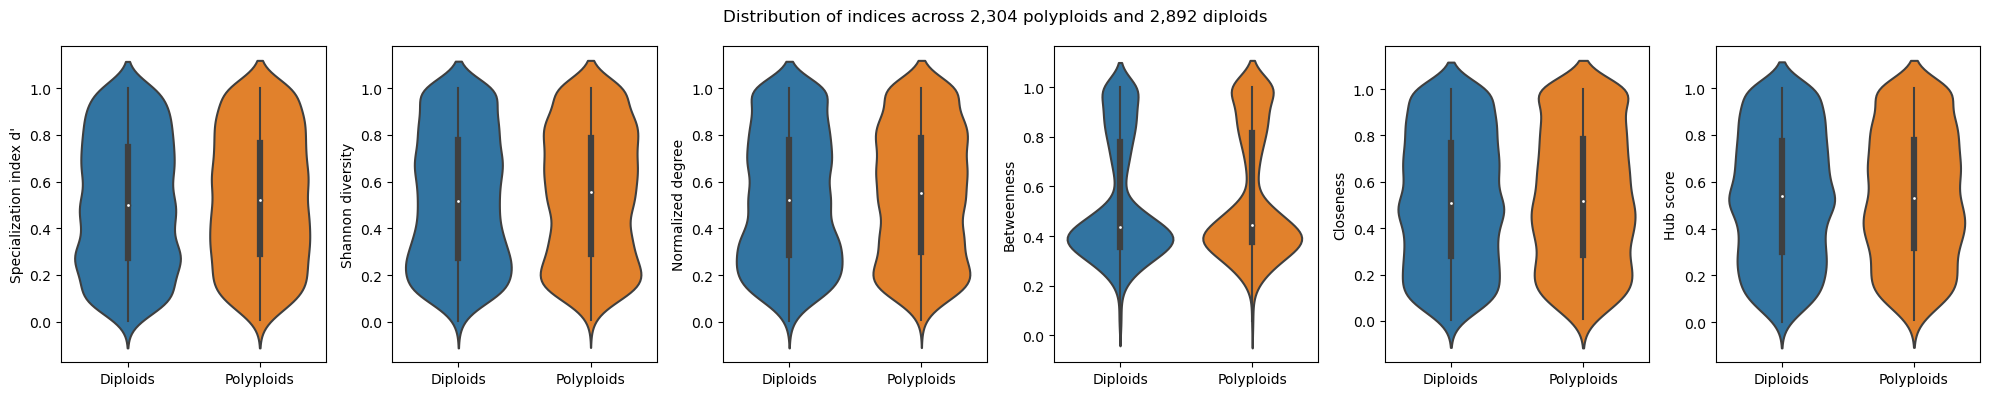

In [190]:
feature_col_to_name = {"standardized_d": "Specialization index d'",
                       "standardized_partner.diversity": "Shannon diversity",
                       "standardized_normalised.degree": "Normalized degree",
                       "standardized_weighted.betweenness": "Betweenness",
                       "standardized_weighted.closeness": "Closeness",
                       "standardized_hubbiness_score": "Hub score"}
features = ["standardized_d", "standardized_partner.diversity", "standardized_normalised.degree",
            "standardized_weighted.betweenness", "standardized_weighted.closeness", "standardized_hubbiness_score"]

fig, ax = plt.subplots(nrows=1, ncols=len(feature_col_to_name), figsize=(20,4))
i = 0
for feat in features:
    sns.violinplot(data=full_dataset, x="is_polyploid", y=feat, ax=ax[i])
    ax[i].set_ylabel(feature_col_to_name[feat])
    ax[i].set_xlabel("")
    i += 1

fig.suptitle(f"Distribution of indices across {full_dataset.loc[full_dataset.is_polyploid == 'Polyploids'].shape[0]:,} polyploids and {full_dataset.loc[full_dataset.is_polyploid == 'Diploids'].shape[0]:,} diploids")
fig.tight_layout()
fig.savefig("../../../data/figures/distribution_of_indices_baseline_full_dataset.jpeg")

In [3]:
def plot_hist_dist_across_var_cat(df: pd.DataFrame, varname: str, outpath: str):
    if varname == "":
        cat = ["all"]
    else:
        subdf = df.dropna(subset=[varname])
        try:
            df[varname].astype(int)
        except Exception as e:
            print(e)
            subdf = subdf.loc[~subdf[varname].str.contains("class")]
        cat = subdf[varname].unique().tolist()
    
    fig, ax = plt.subplots(nrows=len(cat), ncols=len(feature_col_to_name), figsize=(20,4*len(cat)))

    i, j = 0, 0
    for c in cat:
        for feat in features:
            if c == "all":
                data = df
                a = ax[j]
            else:
                data = df.loc[df[varname] == c]
                a = ax[i][j]
            npoly = data.loc[data.is_polyploid == "Polyploids"].shape[0]
            ndi = data.loc[data.is_polyploid == "Diploids"].shape[0]
            
            data.groupby(['is_polyploid'])[feat].plot.hist(alpha=0.5,  ax=a, density=True, stacked=True, legend=(j==len(features)-1))
            a.set_xlabel(feature_col_to_name[feat])
            a.set_ylabel("Freuqency")
            if varname != "":
                a.set_title(f"{varname}={c}\n({npoly:,} polyploids, {ndi:,} diploids)")
            else:
                a.set_title(f"({npoly:,} polyploids, {ndi:,} diploids)")
             
            j += 1
        i += 1
        j = 0
                                
    nsamples = df.shape[0]
    if varname != "":
        nsamples = df.dropna(subset=[varname]).shape[0]
    fig.suptitle(f"Distribution of indices across {nsamples:,} polyploids and diploids" + (f" in different {varname} cateogories\n" if varname != "" else ""), fontsize=14)
    fig.tight_layout()
    fig.savefig(outpath)
    

# def plot_vio_dist_across_var_cat(varname: str, outpath: str):
#     subdf = df
#     if df[varname].dtype == "str":
#         subdf = df.loc[~df[varname].str.contains("class")]
#     cat = subdf[varname].unique().tolist()
#     fig, ax = plt.subplots(nrows=len(cat), ncols=len(feature_col_to_name), figsize=(20,4*len(cat)))

#     i, j = 0, 0
#     for c in cat:
#         for feat in features:
#             data = df.loc[df[varname] == c]
#             npoly = data.loc[data.is_polyploid == "Polyploids"].shape[0]
#             ndi = data.loc[data.is_polyploid == "Diploids"].shape[0]
#             sns.violinplot(data=data, x="is_polyploid", y=feat, ax=ax[i][j])
#             ax[i][j].set_ylabel(feature_col_to_name[feat])
#             ax[i][j].set_xlabel("")
#             ax[i][j].set_title(f"{varname}={c}\n({npoly:,} polyploids, {ndi:,} diploids)")
#             j += 1
#         i += 1
#         j = 0
                                
#     fig.suptitle(f"Distribution of indices across polyploids and diploids" + (" in different {varname} cateogories\n" if varname != "" else ""), fontsize=14)
#     fig.tight_layout()
#     fig.savefig(outpath)
    
    

# def plot_box_dist_across_var_cat(varname: str, outpath: str):
#     subdf = df
#     if df[varname].dtype == "str":
#         subdf = df.loc[~df[varname].str.contains("Unclassified")]
#     cat = subdf[varname].unique().tolist()
#     fig, ax = plt.subplots(nrows=1, ncols=len(feature_col_to_name), figsize=(25,5), sharex=True, sharey=True)

#     for feat in features:
#         a = ax[features.index(feat)]
#         sns.boxplot(data=df, x="is_polyploid", y=feat, hue=varname, ax=a, width=0.5)
#         a.set_xlabel(feature_col_to_name[feat], fontsize=14)
#         a.set_ylabel("")
#         if features.index(feat) == len(features)-1:
#             sns.move_legend(a, "upper right")
#         else:
#             a.legend([], [], frameon=False)
                        
#     fig.suptitle(f"Distribution of indices across {df.shape[0]:,} polyploids and diploids" + (" in different {varname} cateogories\n" if varname != "" else ""), fontsize=14)
#     fig.tight_layout()
#     fig.savefig(outpath)

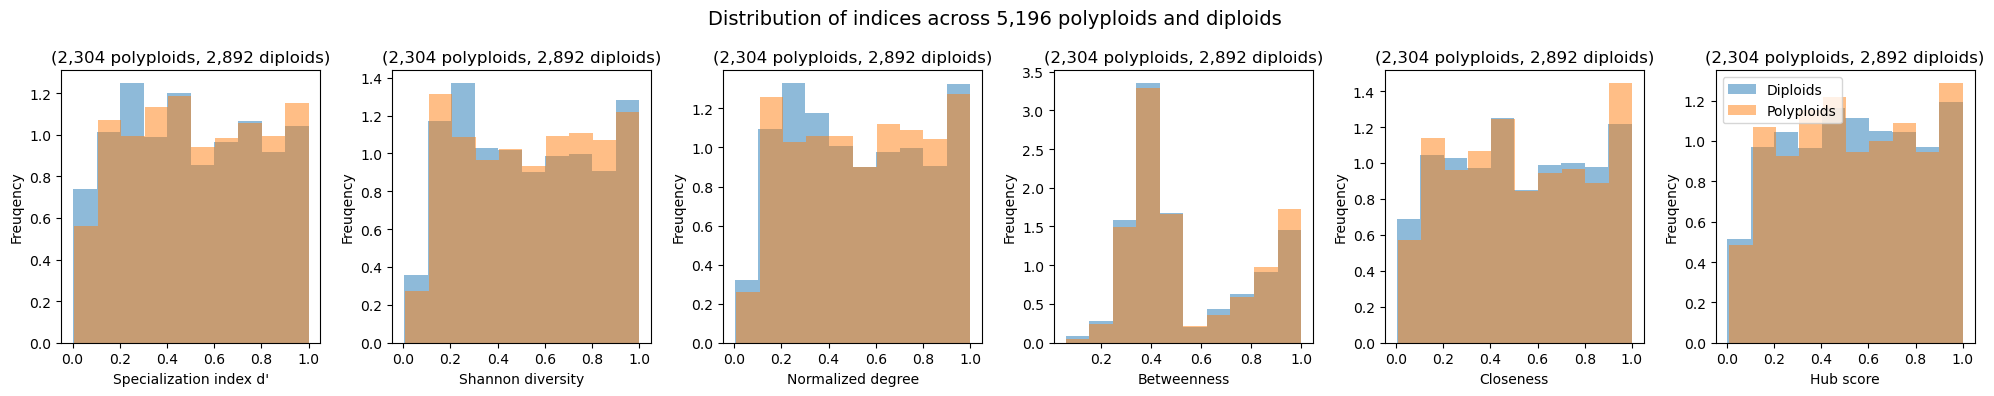

In [194]:
plot_hist_dist_across_var_cat(df=full_dataset, varname="", outpath="../../../data/figures/distribution_of_indices_baseline_full_dataset.jpeg")

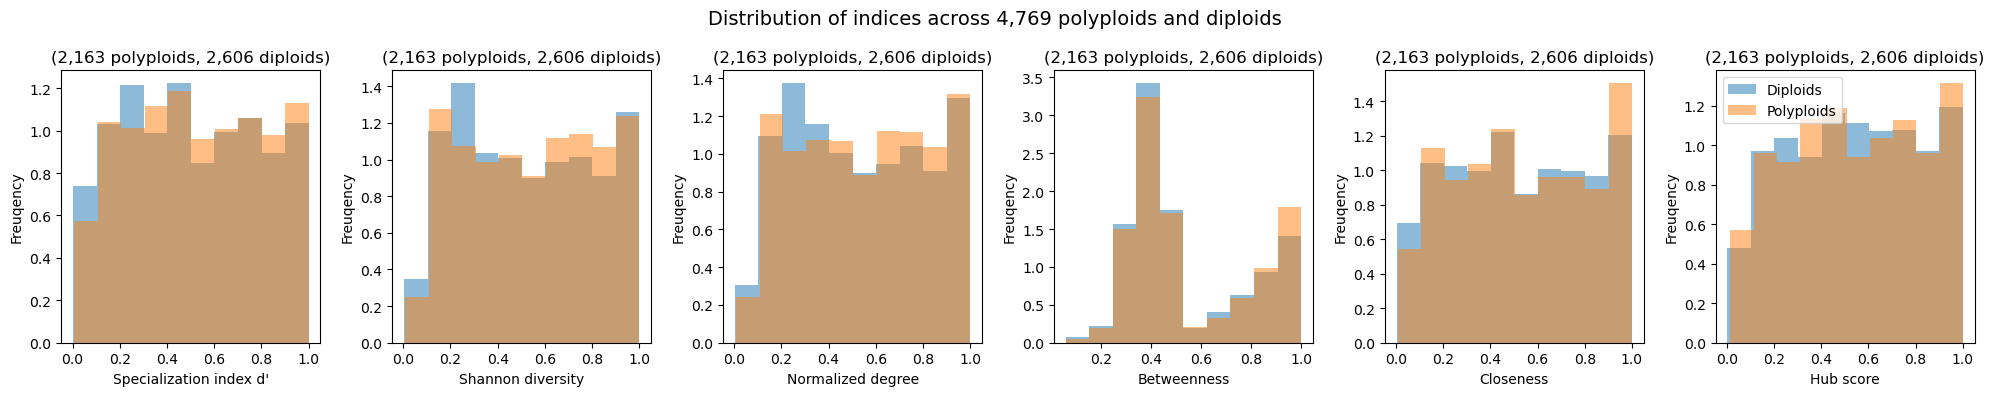

In [195]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="", outpath="../../../data/figures/distribution_of_indices_baseline_limited_dataset.jpeg")

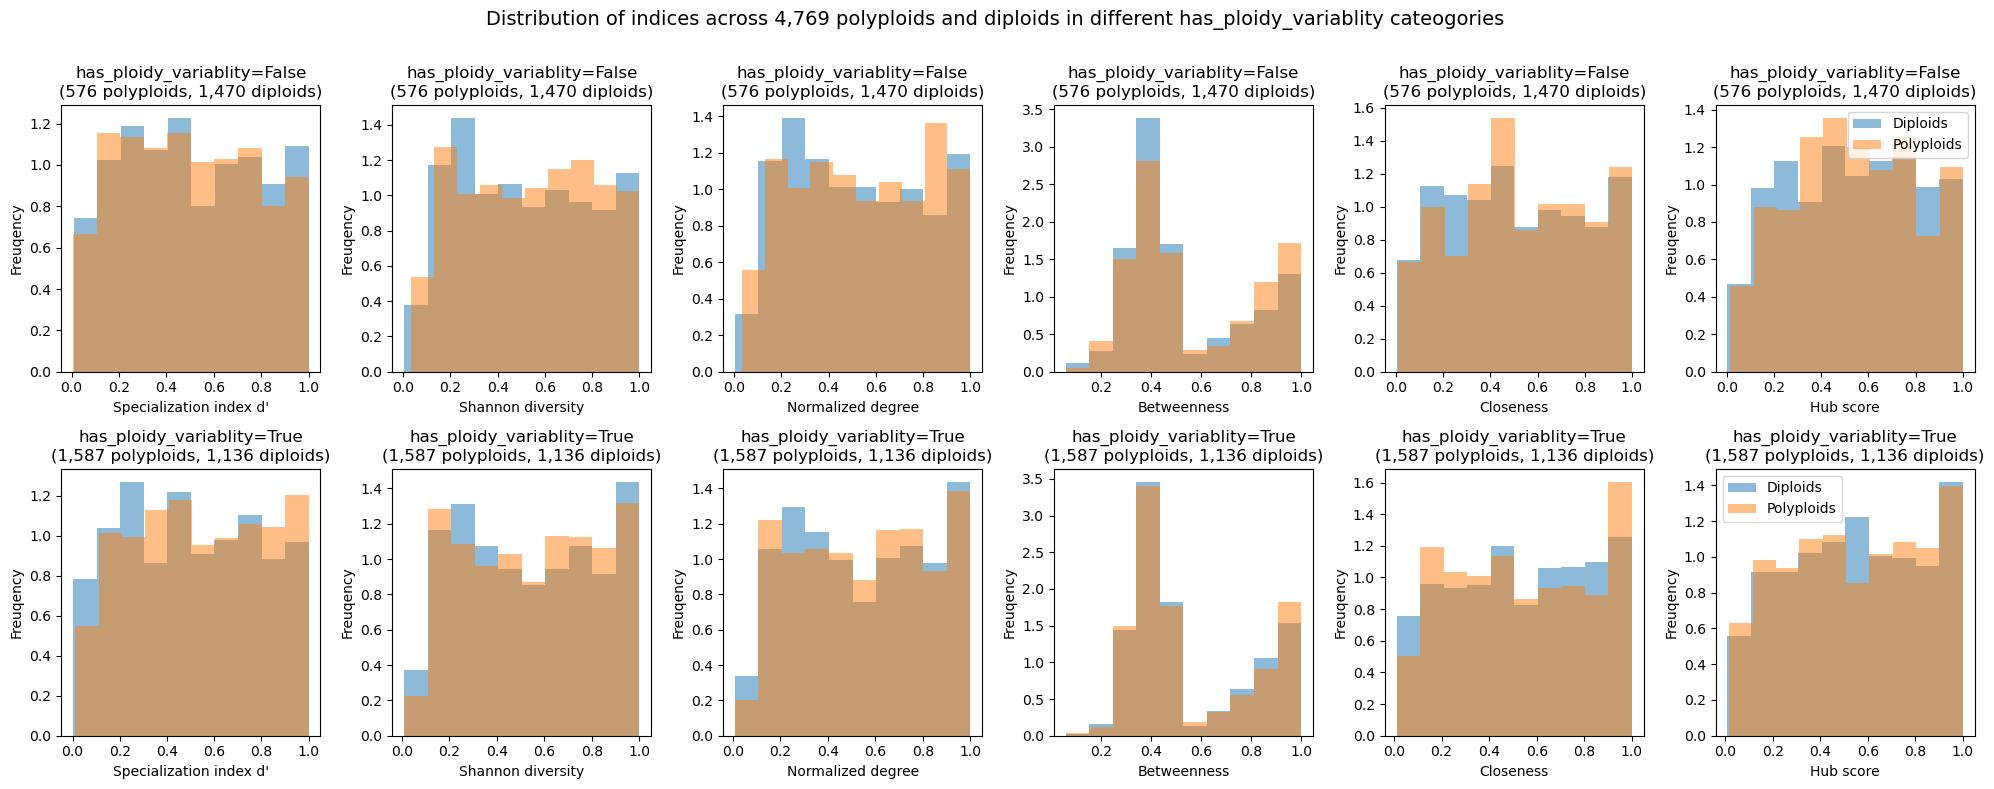

In [196]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="has_ploidy_variablity", outpath="../../../data/figures/spec_indices_dif_ploidy_var.jpeg")

invalid literal for int() with base 10: 'woody'


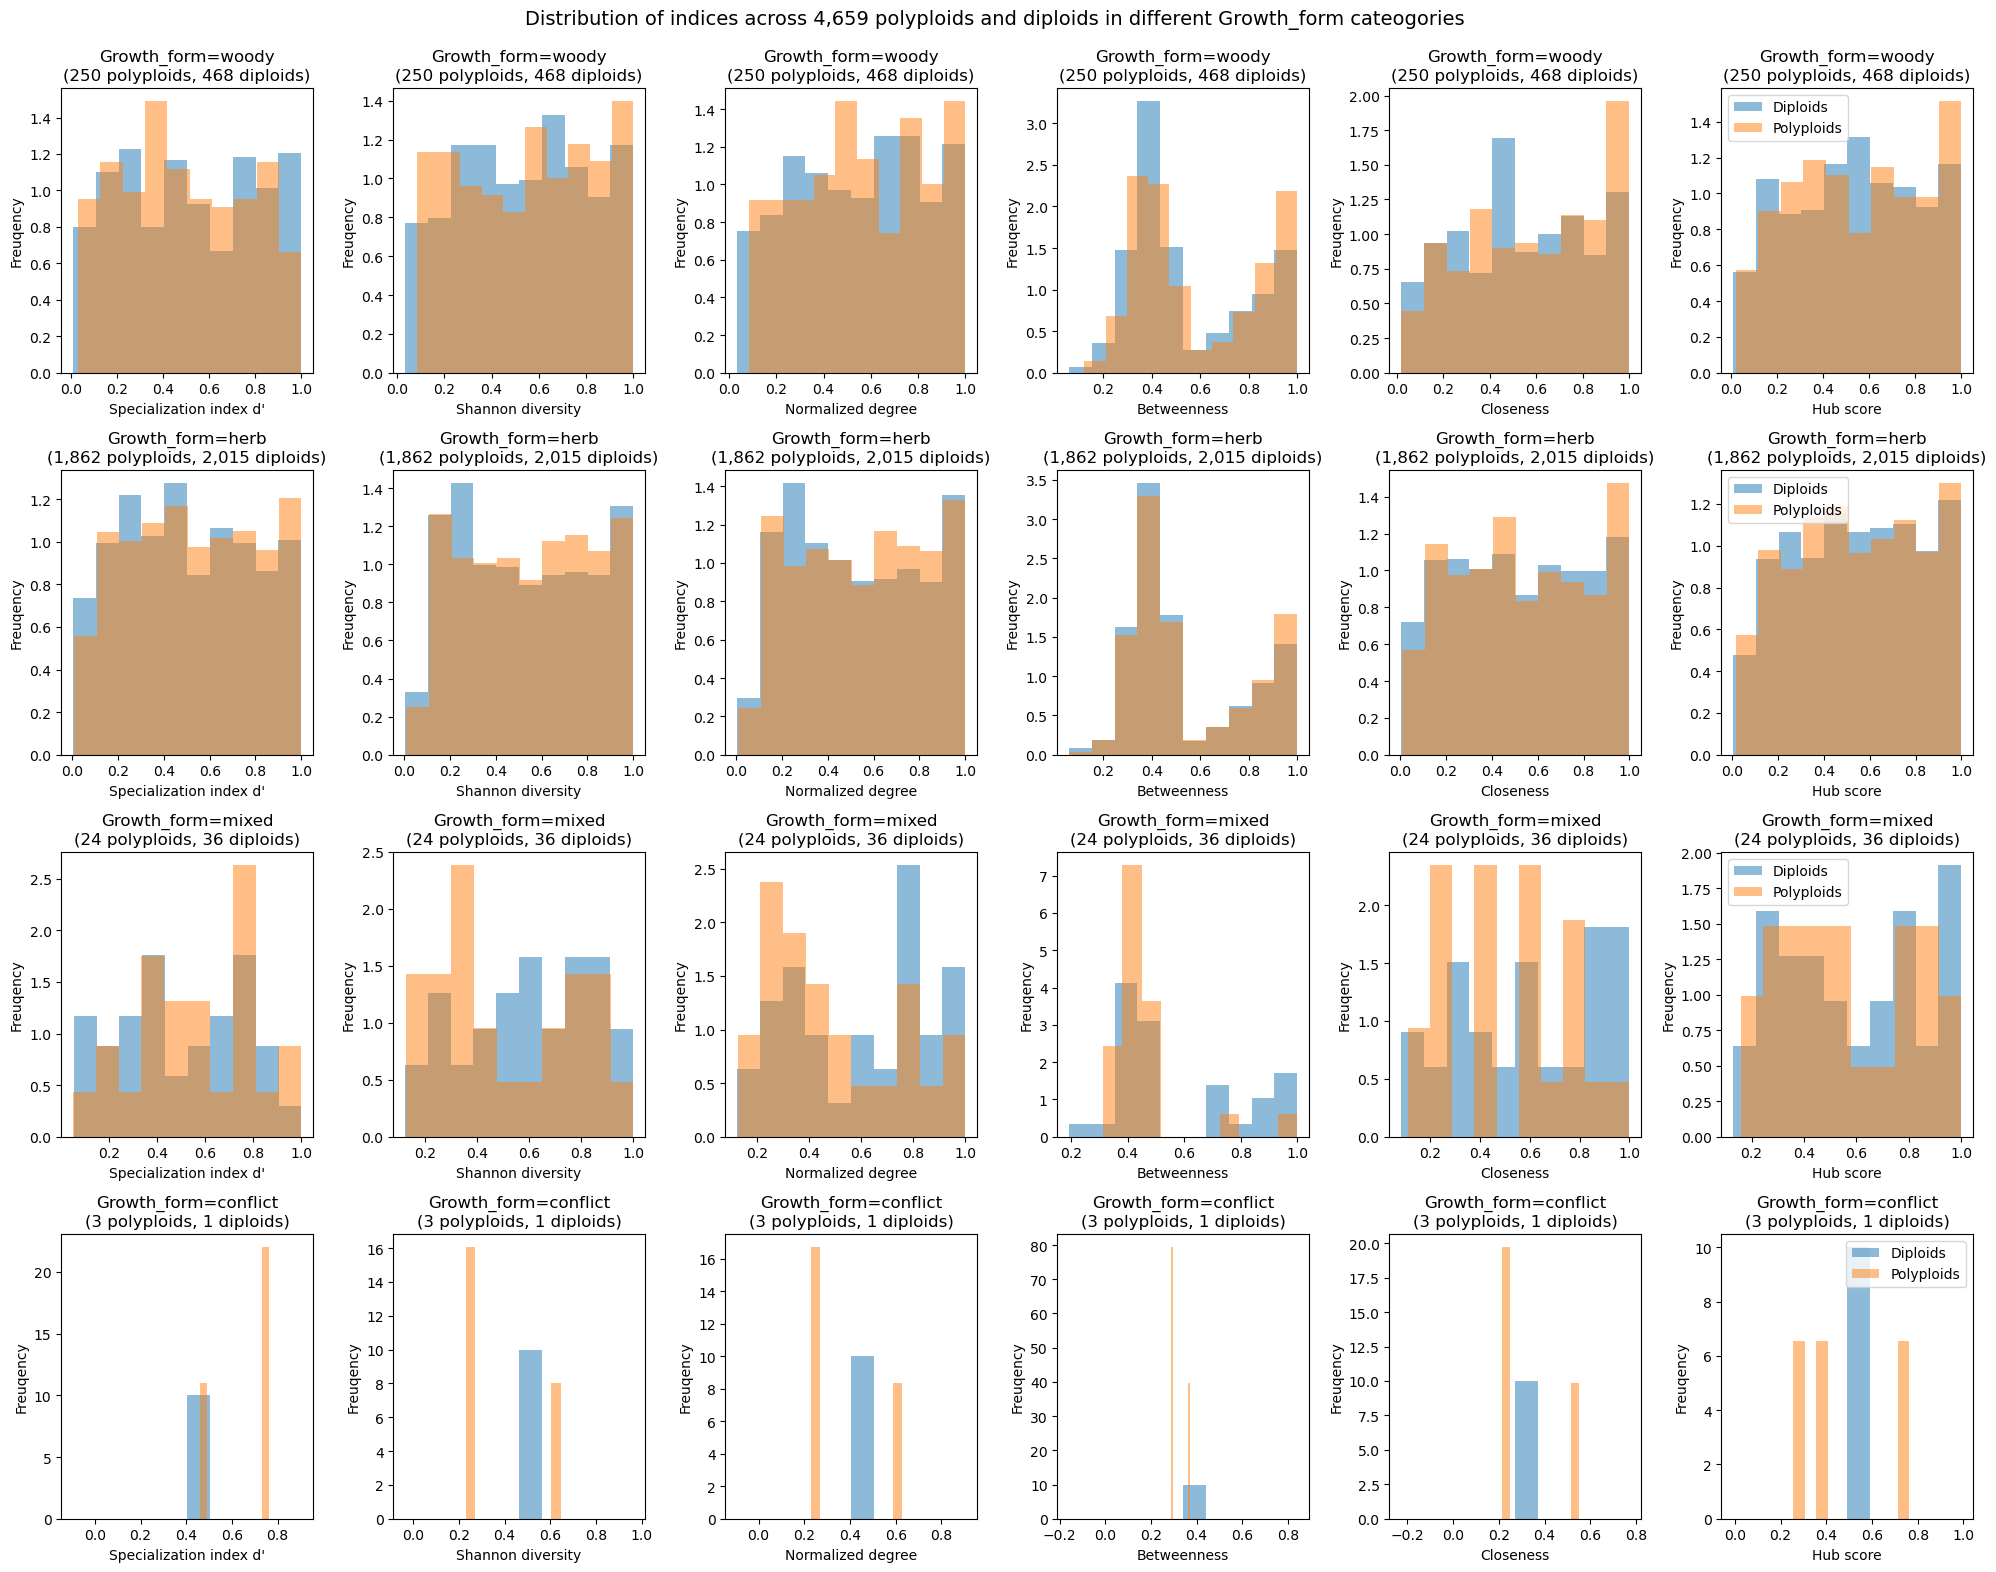

In [224]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="Growth_form", outpath="../../../data/figures/spec_indices_dif_gf.jpeg")

invalid literal for int() with base 10: 'perennial'


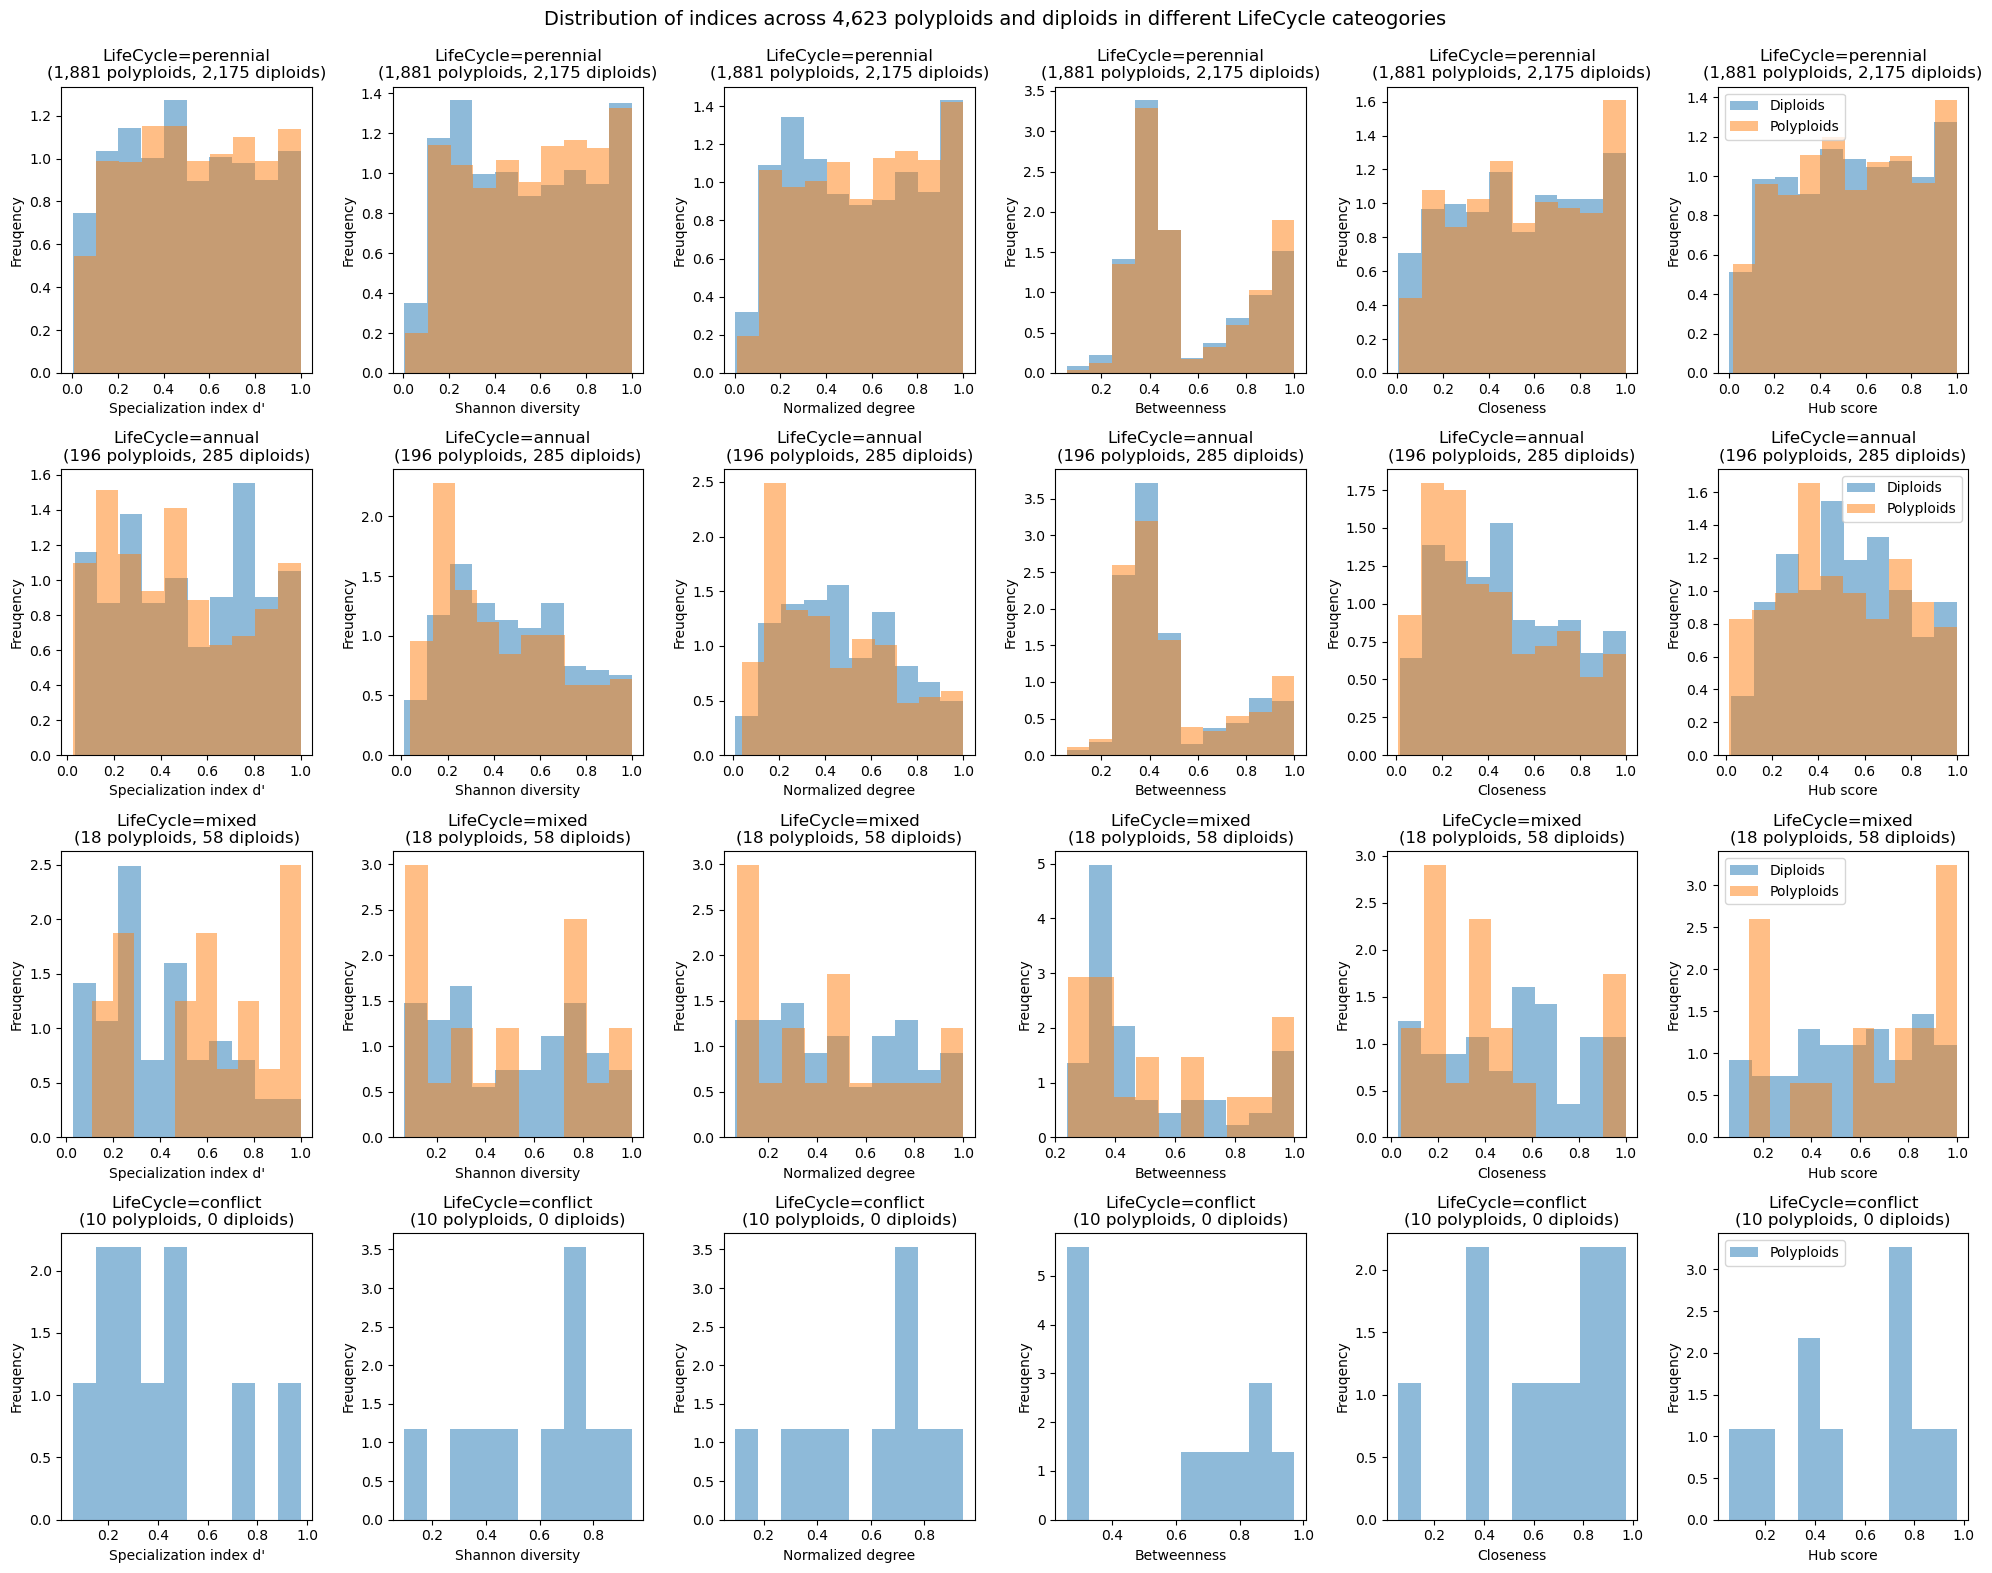

In [225]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="LifeCycle", outpath="../../../data/figures/spec_indices_dif_cl.jpeg")

invalid literal for int() with base 10: 'woody'


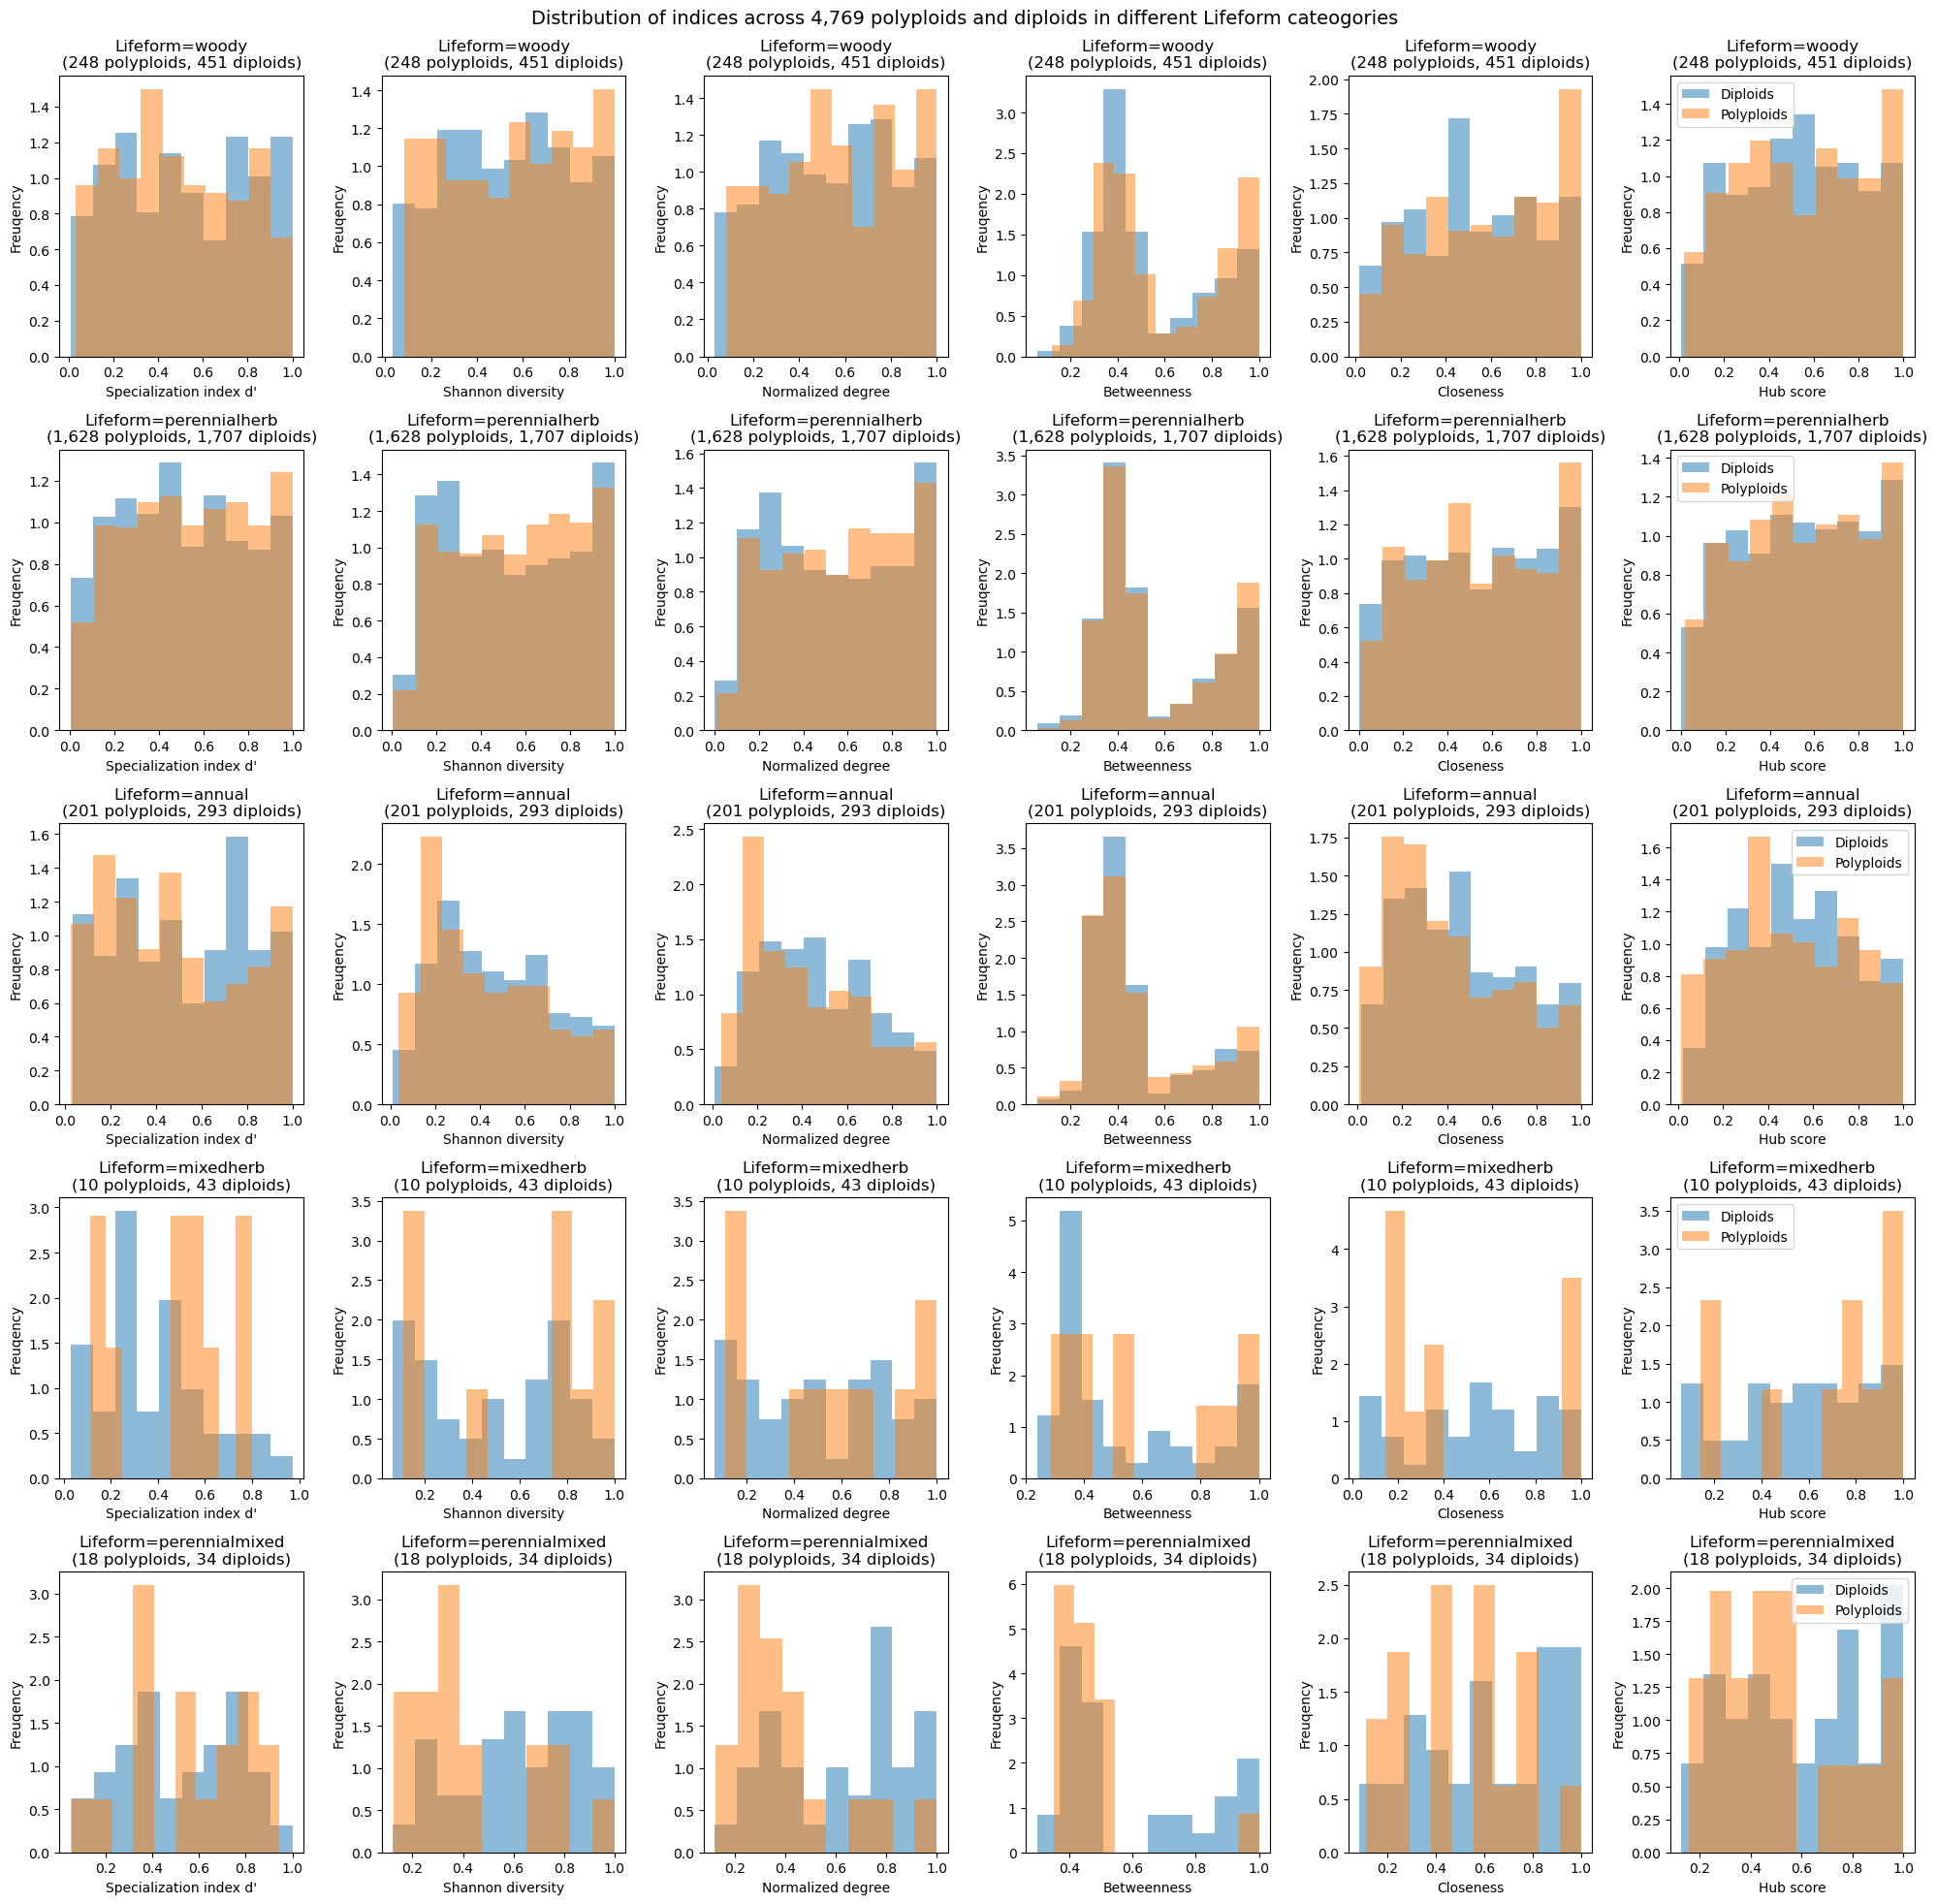

In [197]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="Lifeform", outpath="../../../data/figures/spec_indices_dif_lifeform.jpeg")

invalid literal for int() with base 10: 'restrictive'


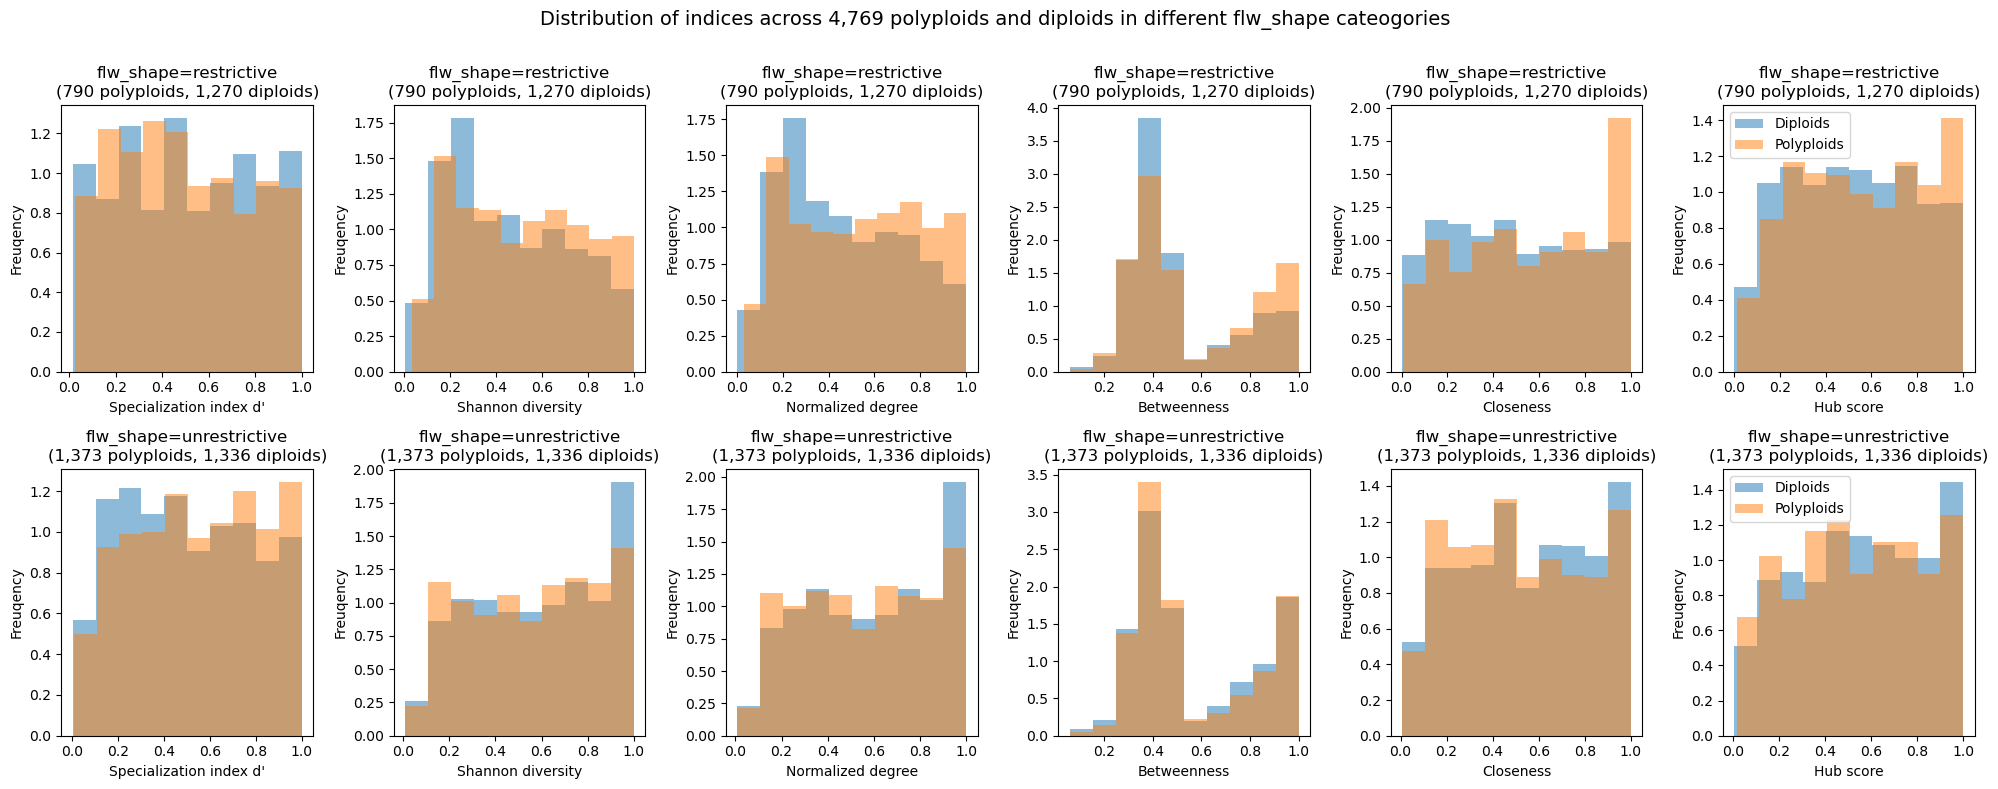

In [198]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="flw_shape", outpath="../../../data/figures/spec_indices_dif_flw_shape.jpeg")

invalid literal for int() with base 10: 'yellow'


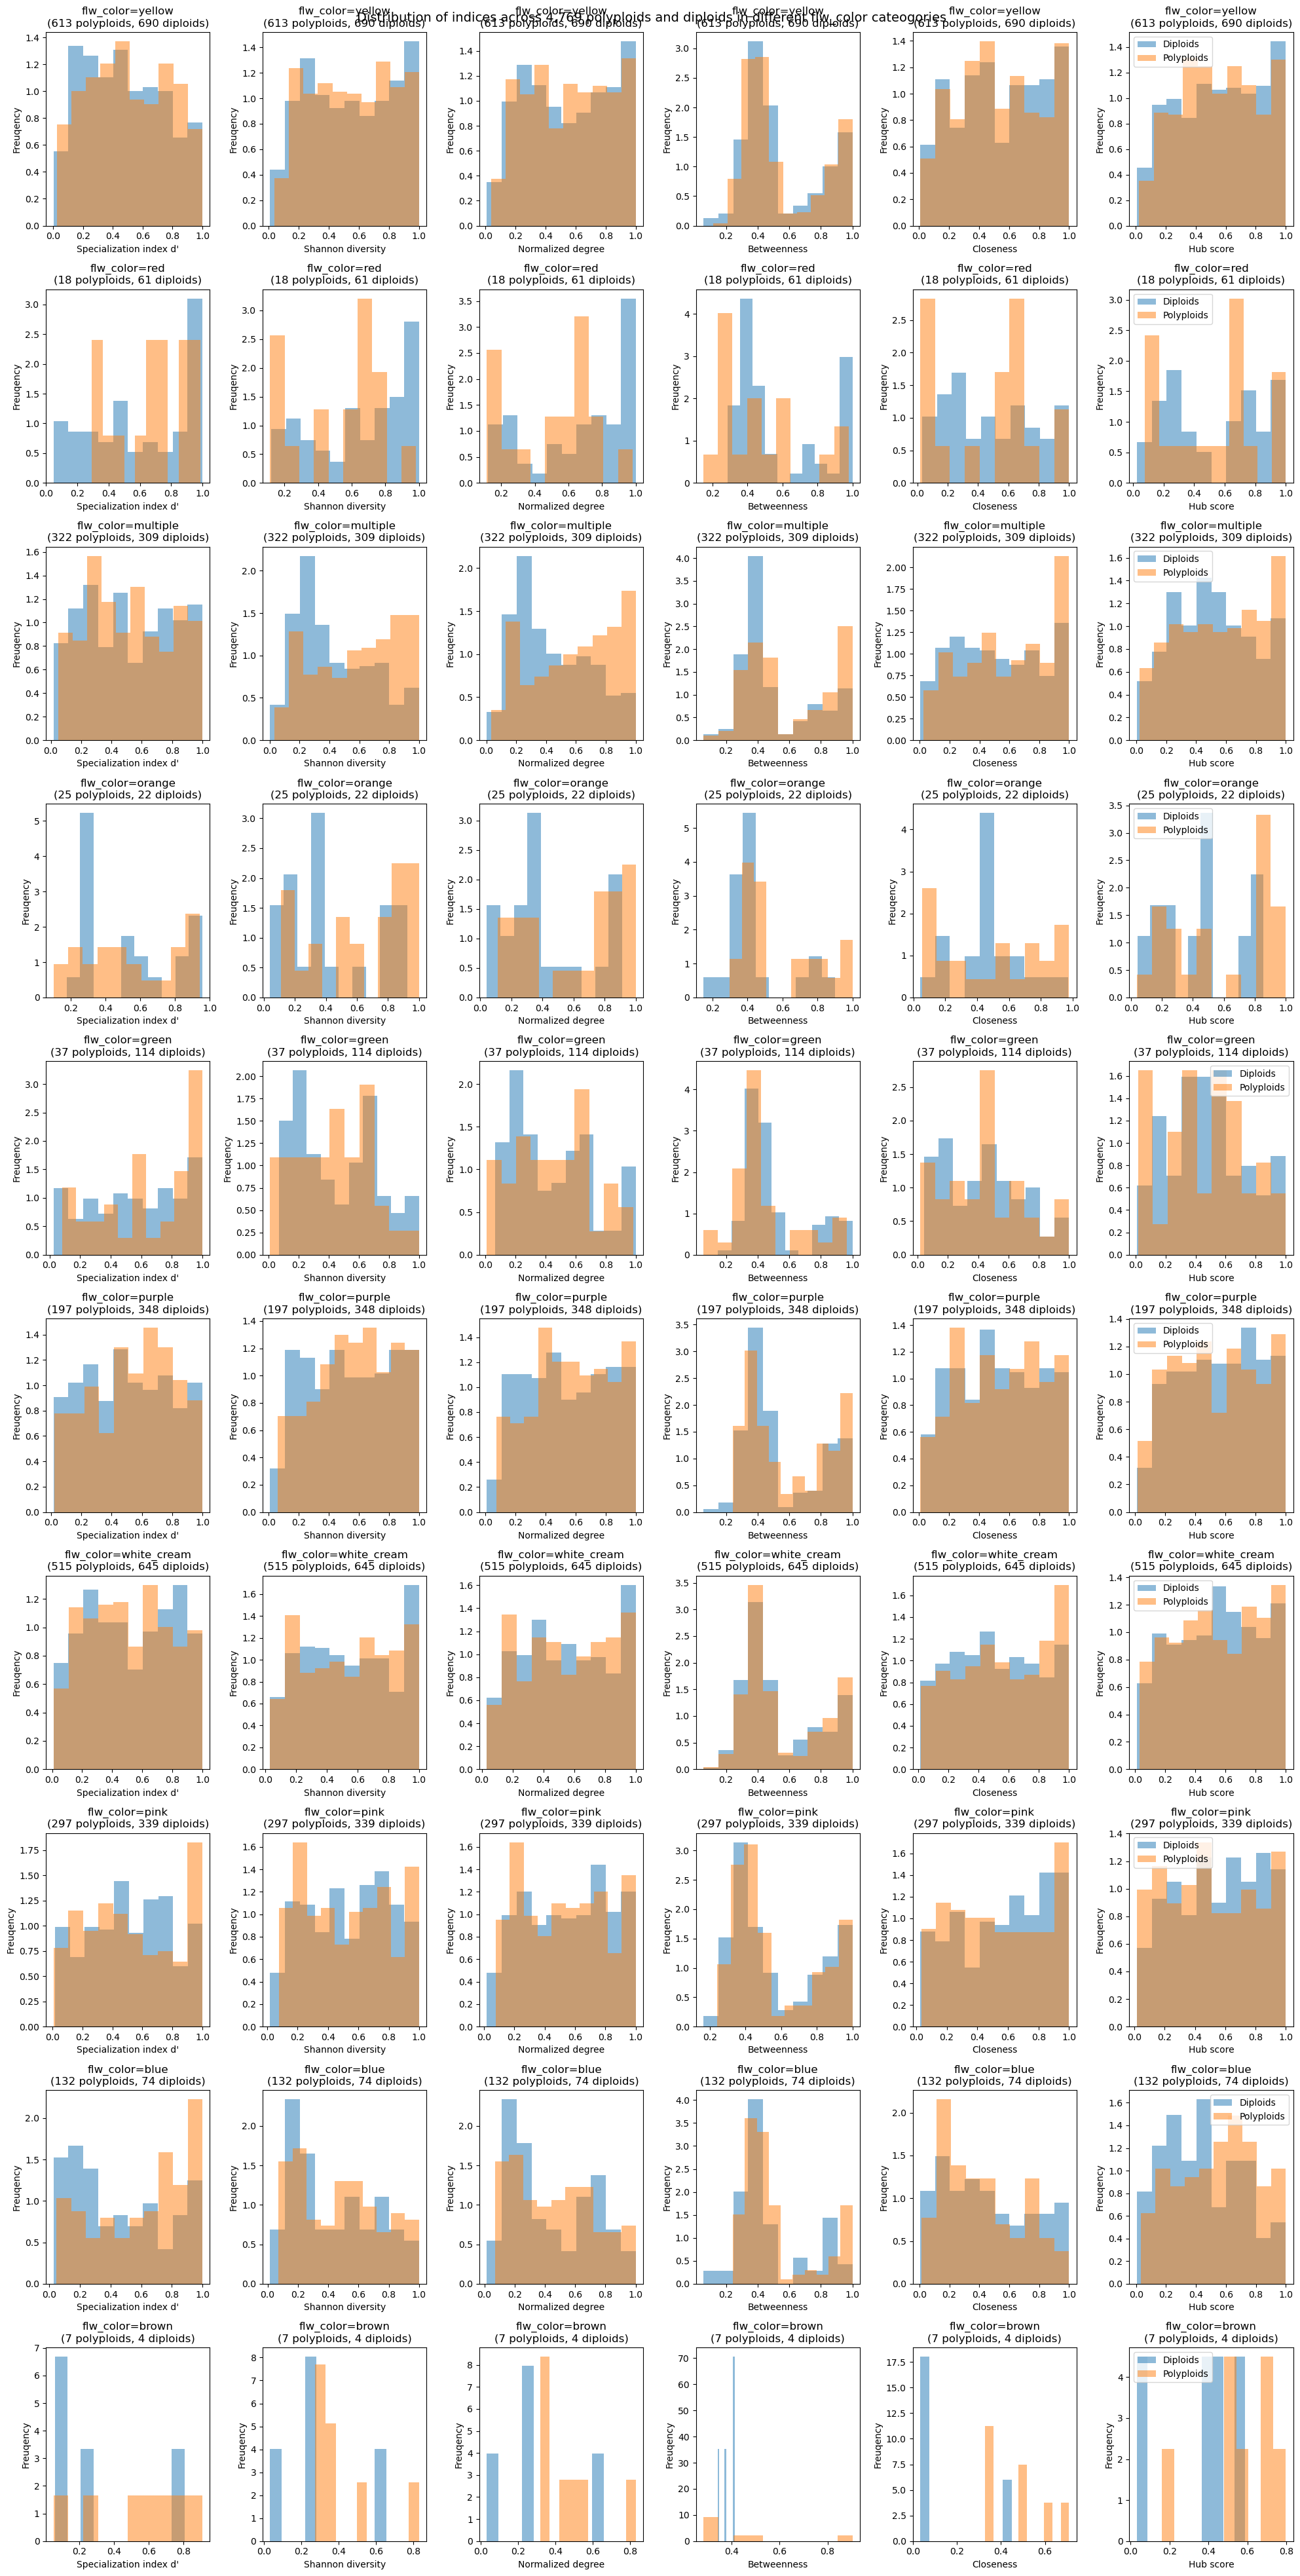

In [199]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="flw_color", outpath="../../../data/figures/spec_indices_dif_flw_color.jpeg")

cannot convert float NaN to integer


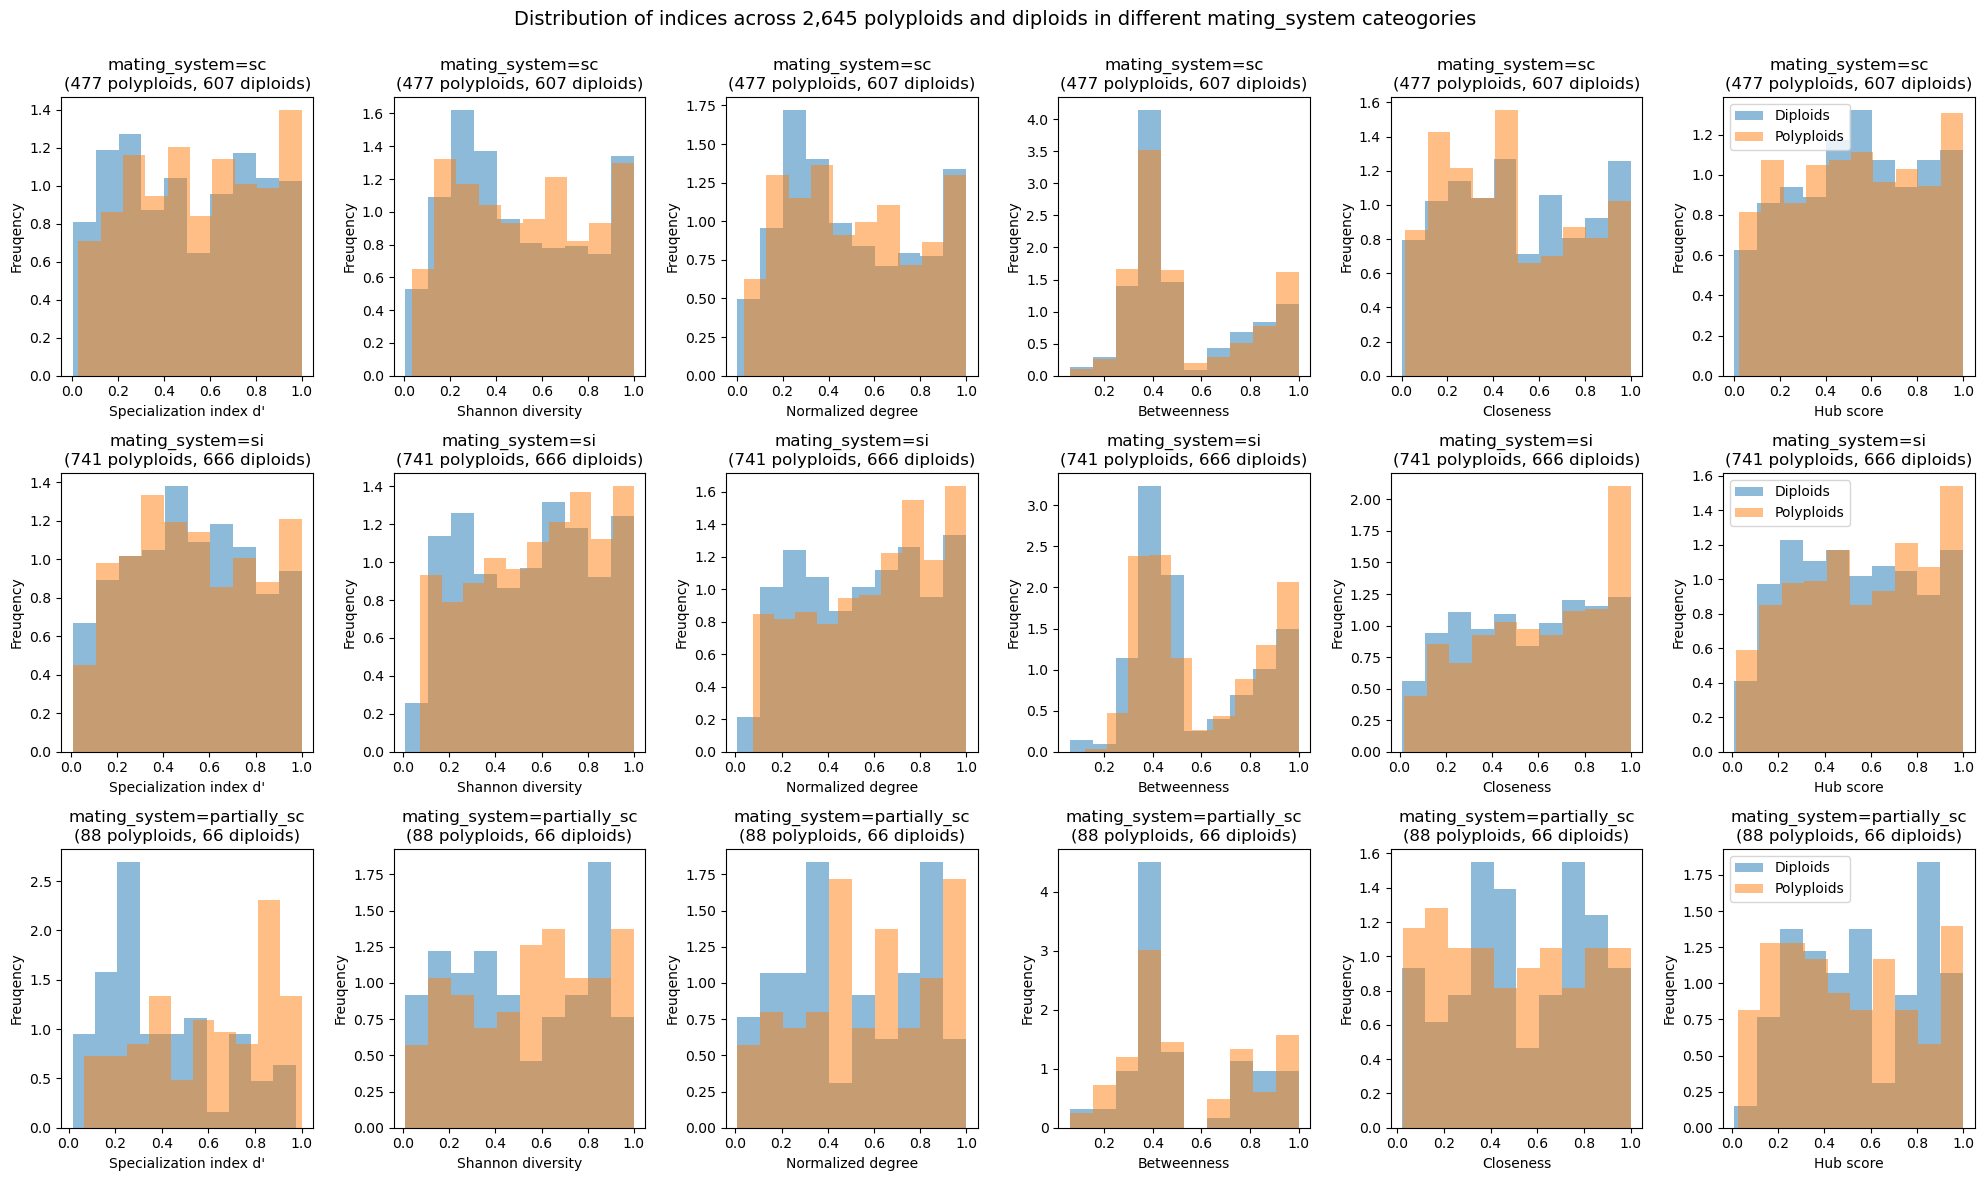

In [200]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="mating_system", outpath="../../../data/figures/spec_indices_dif_ms.jpeg")

/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/groups/itay_mayrose/halabikeren/miniconda3/envs

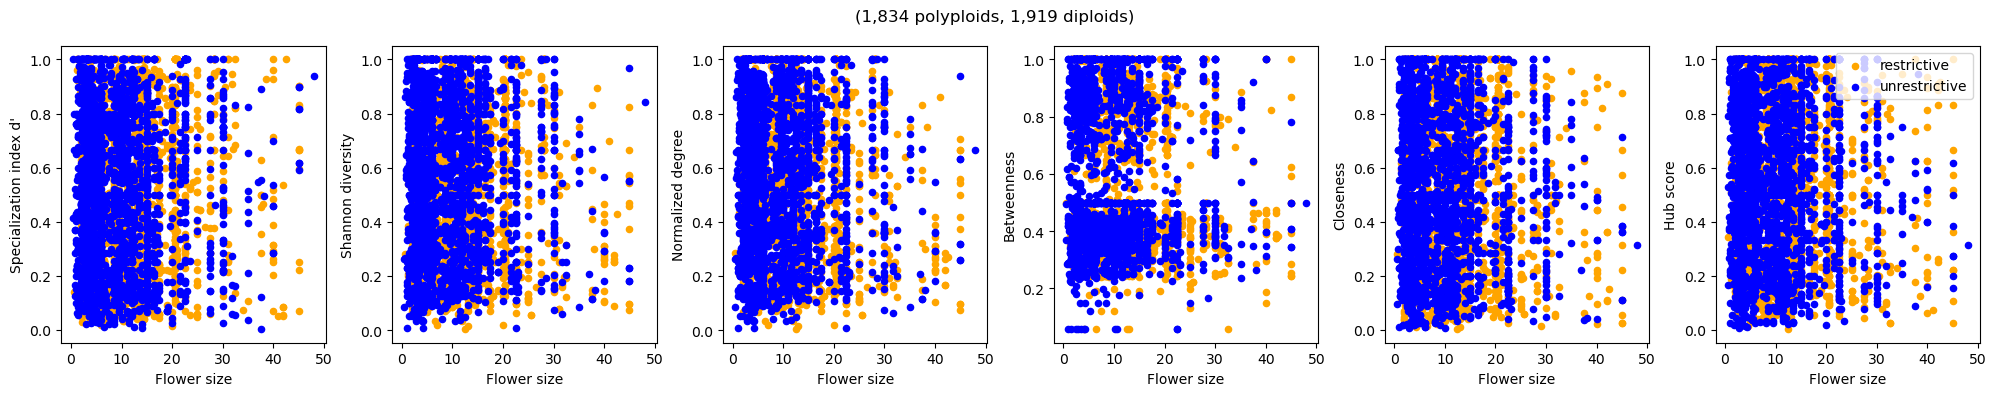

In [201]:
data = df.loc[(df.flw_size_mean < 50)]
fig, ax = plt.subplots(nrows=1, ncols=len(feature_col_to_name), figsize=(20,4))
colors = {"restrictive": "orange", "unrestrictive": "blue"}
npoly = data.loc[data.is_polyploid == "Polyploids"].shape[0]
ndi = data.loc[data.is_polyploid == "Diploids"].shape[0]
   

j = 0
for feat in features:
    a = ax[j]
    data_by_pl = data.groupby(['flw_shape'])
    for g in data_by_pl.groups.keys():
        data_by_pl.get_group(g).plot.scatter(x="flw_size_mean", y=feat, ax=a, label=g,color=colors[g], legend=(j==len(features)-1))
    a.set_ylabel(feature_col_to_name[feat])
    a.set_xlabel("Flower size")
    j += 1

a.legend(loc="upper right")
fig.suptitle(f"({npoly:,} polyploids, {ndi:,} diploids)")
fig.tight_layout()

# debug the inconsistencies between the full dataset and the limited dataset

In [202]:
full_dataset["in_limited"] = full_dataset.apply(lambda rec: pd.notna(rec.has_ploidy_variablity) and
                                                pd.notna(rec.Lifeform) and
                                                pd.notna(rec.flw_color) and
                                                pd.notna(rec.flw_shape), axis=1)

In [203]:
debug = full_dataset.loc[full_dataset.in_limited == False]

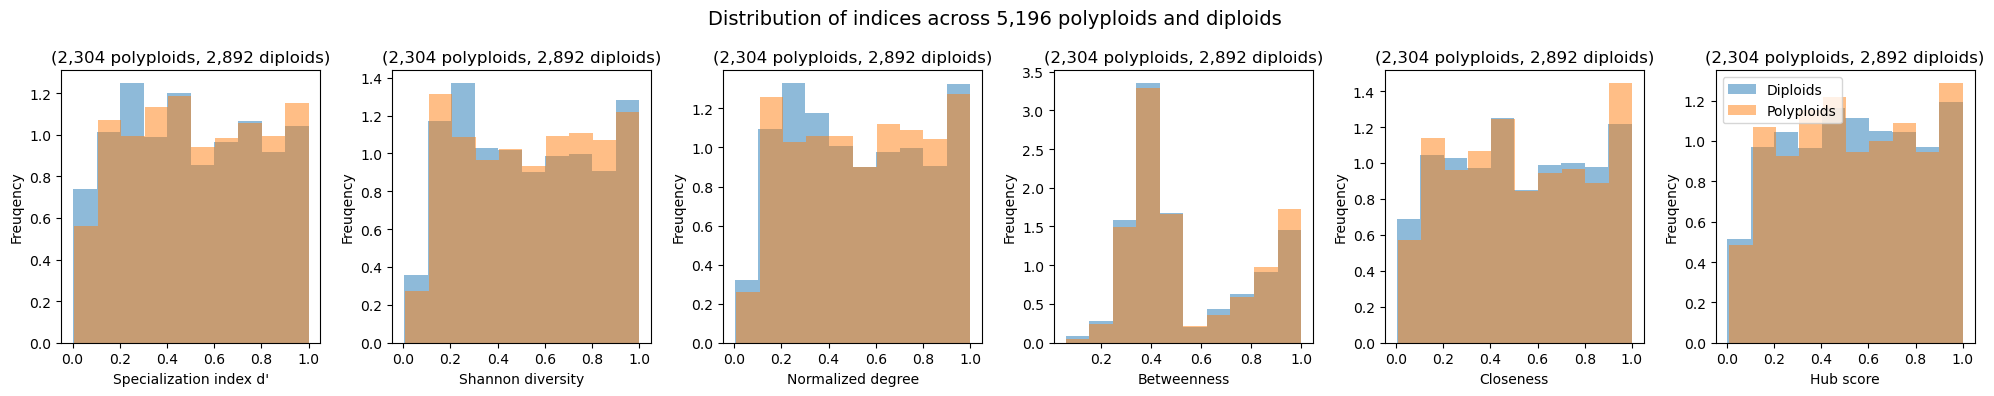

In [204]:
plot_hist_dist_across_var_cat(df=full_dataset, varname="", outpath="../../../data/figures/spec_across_full_data.jpeg")

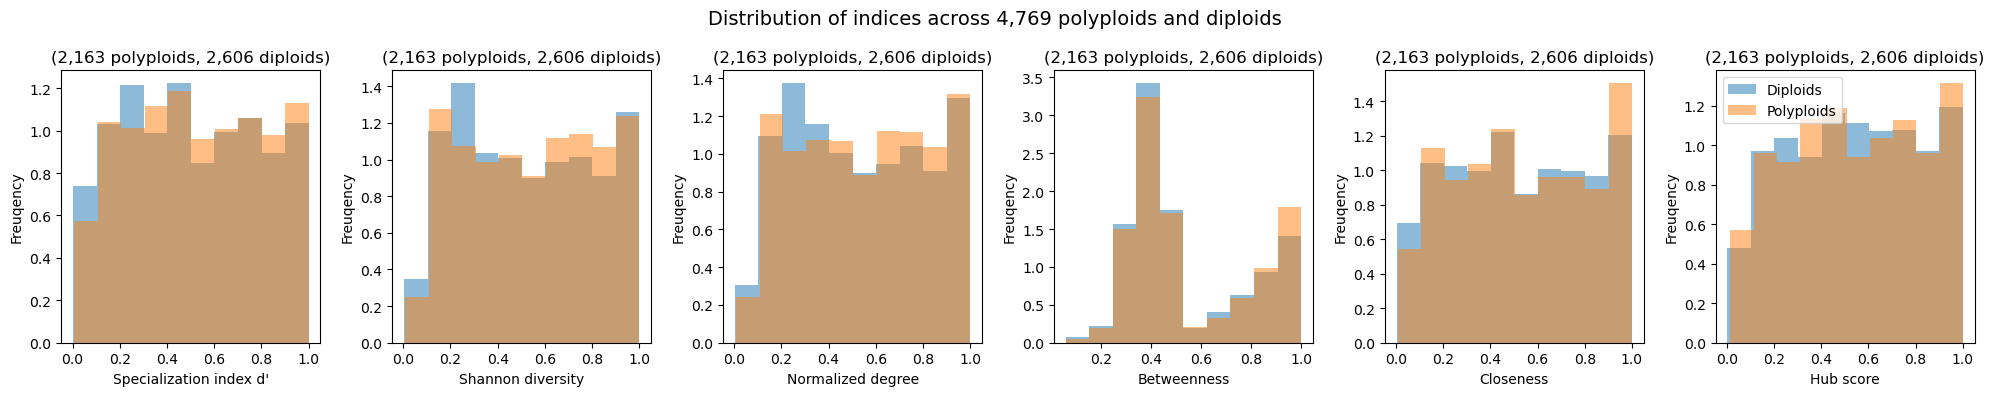

In [205]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="", outpath="../../../data/figures/spec_across_limited_data.jpeg")

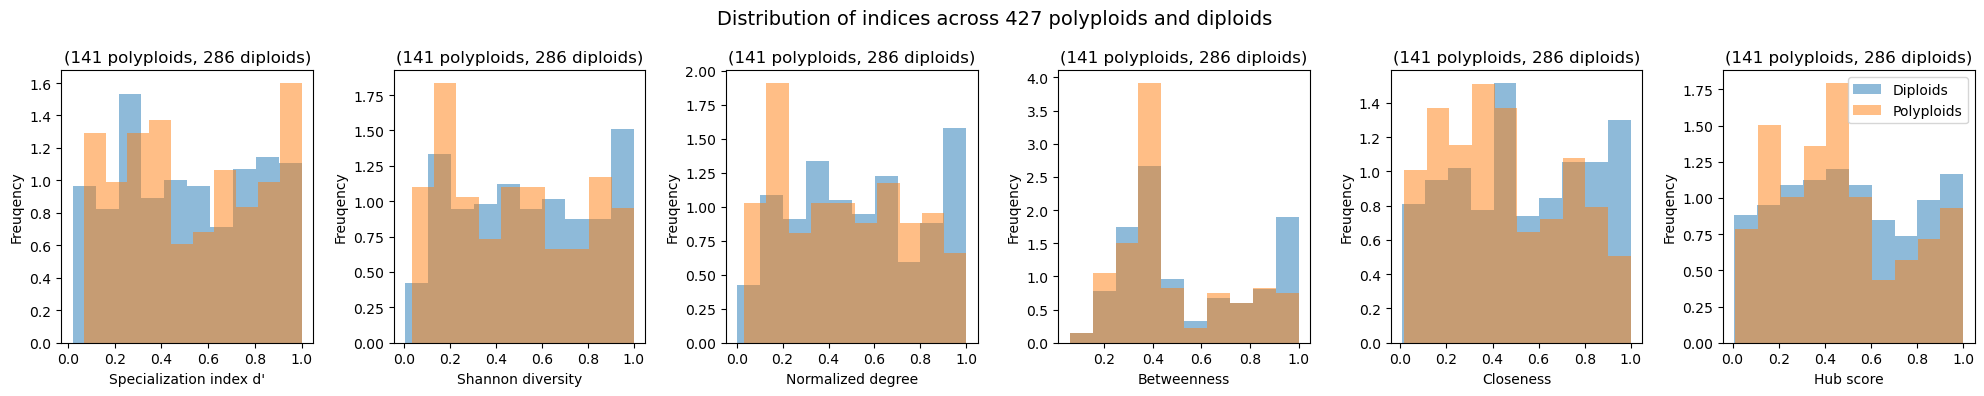

In [206]:
plot_hist_dist_across_var_cat(df=debug, varname="", outpath="../../../data/figures/spec_across_missing_data.jpeg")

In [209]:
debug.groupby("is_polyploid")[["Lifeform", "flw_color", "flw_shape", "mating_system"]].apply(lambda s: s.isna().sum())

Lifeform  flw_color  flw_shape  mating_system
is_polyploid                                               
Diploids             0        286        284            255
Polyploids           0        141        139            136

In [210]:
len(debug.network_id.unique())

199

In [211]:
debug.to_csv("generalist_diploids_excluded_from_analysis.csv", index=False)
# did these come from a specific propblematic study? - mybe we can exclude a small number of studies?
# maybe exclude networks with hummigbird pollinator? how many networks like that we have? send a few examples of the original papers to Nathalia
  # for all nnetworks - check titles automatically - are these bird specific?
# extract list of studies of these and send in slack

In [212]:
df.loc[(df.is_polyploid == "Diploids") & (df["standardized_partner.diversity"] == 1)][["network_type", "network_index", "Plant", "partner.diversity"]].Plant.unique()

array(['alstroemeria aurea', 'berberis darwinii', 'heracleum sphondylium',
       'trifolium pratense', 'daucus carota', 'ranunculus bulbosus',
       'ranunculus acris', 'thymus pulegioides', 'scabiosa columbaria',
       'geranium sylvaticum', 'carduus nutans', 'vicia benghalensis',
       'centaurea solstitialis', 'mentha pulegium', 'lupinus argenteus',
       'melilotus officinalis', 'geranium pratense',
       'coreopsis lanceolata', 'baptisia australis', 'echinacea simulata',
       'dryas octopetala', 'alstonia macrophylla',
       'eschscholzia californica', 'androsace septentrionalis',
       'erythronium grandiflorum', 'heterotheca villosa',
       'echium wildpretii', 'erigeron speciosus', 'solidago multiradiata',
       'banisteriopsis muricata', 'nepenthes pervillei',
       'marrubium vulgare', 'cistus monspeliensis', 'myrsine coriacea',
       'dryas integrifolia', 'opuntia stricta', 'cirsium arvense',
       'grindelia chiloensis', 'angelica sylvestris',
       'leptosp

In [213]:
full_dataset.loc[full_dataset['standardized_partner.diversity'] == 1].groupby("is_polyploid").Plant.count()

is_polyploid
Diploids      196
Polyploids    166
Name: Plant, dtype: int64

In [214]:
debug.loc[debug['standardized_partner.diversity'] == 1].groupby("is_polyploid").Plant.count()

is_polyploid
Diploids      20
Polyploids     4
Name: Plant, dtype: int64

In [215]:
limited_dataset.loc[limited_dataset['standardized_partner.diversity'] == 1].groupby("is_polyploid").Plant.count()

is_polyploid
Diploids      176
Polyploids    162
Name: Plant, dtype: int64

In [216]:
limited_dataset.groupby("is_polyploid").Plant.count() / limited_dataset.shape[0]

is_polyploid
Diploids      0.546446
Polyploids    0.453554
Name: Plant, dtype: float64

In [217]:
full_dataset.groupby("is_polyploid").Plant.count() / full_dataset.shape[0]

is_polyploid
Diploids      0.556582
Polyploids    0.443418
Name: Plant, dtype: float64